# $\S$ Supervised Learning

# $\S$ 2.3. Two Simple Approaches to Prediction: Least Squares and Nearest Neighbors

In this section we develop two simple but powerful prediction methods: The linear model fit by least squares and the $k$-nearest-neighbor (kNN) prediction rule.

The linear model makes huge assumptions about structure and yields stable but possibly inaccurate predictions. The method of kNN makes very mild structural assumptions: Its predictions are often accurate but can be unstable.

## $\S$ 2.3.3 From Least Squares to Nearest Neighbors

The linear decision boundary from least squares is very smooth, and apparently stable to fit. It does appear to rely heavily on the assumption that a linear decision boundary is appropriate. In language we will develop shortly, it has low variance and potentially high bias.

On the other hand, the $k$-nearest-neighbor procedures do not appear to rely on any stringent assumptions about the underlying data, and can adapt to any situation. However, any particular subregion of the decision boundary depends on a handful of input points and their particular positions, and is thus wiggly and unstable—high variance and low bias.

Let's expose the oracle first! The data is generated with following steps:
1. Generate 10 means $m_k$ from a bivariate Gaussian for each class  

  \begin{equation}
  m_k \sim \begin{cases}
  N((1,0)^T, \mathbf{I}) & \text{ for BLUE}, \\
  N((0,1)^T, \mathbf{I}) & \text{ for ORANGE}
  \end{cases}
  \end{equation}
  
2. For each class, we generate 100 observations as follows:
  1. Pick an $m_k$ at random with probability 1/10
  2. Generate $x_i \sim N(m_k, \mathbf{I}/5)$


In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt

In [5]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

In [2]:
# define a function generate_data(sample_size)
def generate_data(sample_size:int)->tuple:
    # Parameters for mean distributions
    mean_blue = [1, 0]
    mean_orange = [0, 1]
    mean_cov = np.eye(2)
    mean_size = 10
    
    # Additional parameters for blue and orange distributions
    sample_cov = np.eye(2)/5
    
    # Generate mean components for blue and orange (10 means for each)
    sample_blue_mean = np.random.multivariate_normal(mean_blue, mean_cov, mean_size)
    sample_orange_mean = np.random.multivariate_normal(mean_orange, mean_cov, mean_size)
    
    # Generate (n=sample_size) blue points
    sample_blue = np.array([
        np.random.multivariate_normal(sample_blue_mean[random.randint(0, 9)],
                                      sample_cov)
        for _ in range(sample_size)
    ])
    # Generate (n=sample_size) 0
    y_blue = [0 for _ in range(sample_size)]

    # Generate (n=sample_size) orange points
    sample_orange = np.array([
        np.random.multivariate_normal(sample_orange_mean[random.randint(0, 9)],
                                      sample_cov)
        for _ in range(sample_size)
    ])
    # Generate (n=sample_size) 1
    y_orange = [1 for _ in range(sample_size)]

    data_x = np.concatenate((sample_blue, sample_orange), axis=0)
    data_y = np.concatenate((y_blue, y_orange))
    return data_x, data_y

In [7]:
len(sample_blue)

100

In [10]:
len(data_x)

200

In [12]:
len(data_y)

200

In [3]:
sample_size = 100
data_x, data_y = generate_data(sample_size)
sample_blue = data_x[data_y == 0, :]
sample_orange = data_x[data_y == 1, :]

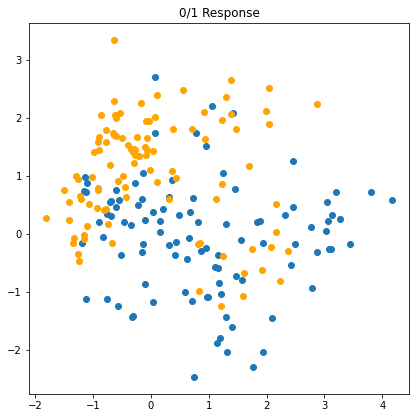

In [26]:
# Plot
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2, 1)

ax1.plot(sample_blue[:, 0], sample_blue[:, 1], 'o')
ax1.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax1.set_title('0/1 Response')
plt.show()

plot_x_min, plot_x_max = ax1.get_xlim()
plot_y_min, plot_y_max = ax1.get_ylim()

## $\S$ 2.3.1. Linear Models and Least Squares

> The linear model has been a mainstay of statistics for the past 30 years and remains one of our most important tools.

### Linear Models

Given a vector of inputs $X^T = (X_1, \cdots, X_p)$, we predict the output $Y$ via the model

\begin{equation}
\hat{Y} = \hat{\beta}_0 + \sum^p_{j=1}X_j\hat{\beta}_j = X^T\hat{\beta}=
\begin{bmatrix}
1&X_1&X_2&\cdots&X_p
\end{bmatrix}\begin{bmatrix}
\hat{\beta}_0\\
\hat{\beta}_1\\
\vdots\\
\hat{\beta}_p\\
\end{bmatrix}
\end{equation}

where the constant variable 1 in $X^T = (1, X_1, \cdots, X_p)$ and $\hat{\beta}^T = (\beta_0, \beta_1, \cdots, \beta_p)$. The term $\hat\beta_0$ is the intercept, a.k.a. the _bias_ in machine learning.

Here we are modeling a single output, so $\hat{Y}$ is a scalar; in general $\hat{Y}$ can be a $K$-vector, in which case $\beta$ would be a $p \times K$ matrix of coefficients.

In the $(p+1)$-dimensional input-output space, $(X, \hat{Y})$ represents a hyperplane. If the constant is included in $X$, then the hyperplane includes the origin and is a subspace; if not, is is an affine set cutting the $Y$-axis at the point $(0, \hat\beta_0)$. From now on we assume that the intercept is included in $\hat\beta$.

Viewed as a function over the $p$-dimensional input space,

\begin{equation}
f(X) = X^T\beta
\end{equation}

is linear, and the gradient $f'(X) = \beta$ is a vector in input space that points in the steepest uphill direction.

### How to fit the model: Least squares

Least squares pick the coefficients $\beta$ to minimize the residual sum of squares

\begin{equation}
RSS(\beta) = \sum^N_{i=1}(y_i - x_i^T\beta)^2 = (\mathbf{y} - \mathbf{X}\beta)^T(\mathbf{y} - \mathbf{X}\beta)\\
=(\mathbf{y}^T - \beta^T\mathbf{X}^T)(\mathbf{y} - \mathbf{X}\beta)\\
=\mathbf{y}^T\mathbf{y}-\mathbf{y}^T\mathbf{X}\beta-\beta^T\mathbf{X}^T\mathbf{y}+\beta^T\mathbf{X}^T\mathbf{X}\beta,
\end{equation}

since $\mathbf{y}^T\mathbf{X}\beta$ is a scalar quantity, thus $\mathbf{y}^T\mathbf{X}\beta = (\mathbf{y}^T\mathbf{X}\beta)^T=\beta^T\mathbf{X}^T\mathbf{y}$ Then 

\begin{equation}
RSS(\beta) = \mathbf{y}^T\mathbf{y}-\beta^T\mathbf{X}^T\mathbf{y}-\beta^T\mathbf{X}^T\mathbf{y}+\beta^T\mathbf{X}^T\mathbf{X}\beta\\
= \mathbf{y}^T\mathbf{y}-2\beta^T\mathbf{X}^T\mathbf{y}+\beta^T\mathbf{X}^T\mathbf{X}\beta
\end{equation}

where $\mathbf{X}$ is an $N \times p$ matrix with each row an input vector, and $\mathbf{y}$ is an $N$-vector of outputs in the training set.

$RSS(\beta)$ is a quadratic function of the parameters, and hence its minimum always exists, but may not be unique.

Differentiating w.r.t. $\beta$ we get the *normal equations*

\begin{equation}
\frac{\partial{RSS}}{\partial{\beta}}=-2\mathbf{X}^T\mathbf{y}+2\mathbf{X}^T\mathbf{X}\beta
\end{equation}


\begin{equation}
\mathbf{X}^T(\mathbf{y} - \mathbf{X}\beta) = 0.
\end{equation}

If $\mathbf{X}^T \mathbf{X}$ is nonsingular, then the unique solution is given by

\begin{equation}
\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y},
\end{equation}

and the *fitted value* at the $i$th input $x_i$ is 

\begin{equation}
\hat{y}_i = \hat{y}(x_i) = x_i^T\hat{\beta}.
\end{equation}

At an arbitrary input $x_0$ the prediction is

\begin{equation}
\hat{y}(x_0) = x_0^T \hat\beta.
\end{equation}

The entire fitted surface is characterized by the $p$ parameters. Intuitively, it seems that we do not need a very large data set to fit such a model.

In [8]:
# Linear regression
mat_x = np.hstack((np.ones((sample_size*2, 1)), data_x))
mat_xt = np.transpose(mat_x)
vec_y = data_y

# Solve (X^T*X)b = X^T*y for b
ols_beta = np.linalg.solve(np.matmul(mat_xt, mat_x), np.matmul(mat_xt, vec_y))

print('=== Estimated Coefficients for OLS ===')
print('beta0:', ols_beta[0], '(constant)')
print('beta1:', ols_beta[1])
print('beta2:', ols_beta[2])

=== Estimated Coefficients for OLS ===
beta0: 0.4409182185615338 (constant)
beta1: -0.09141131859617739
beta2: 0.20146884857094918


In [10]:
len(mat_x)

200

### Linear model in a classification context

FIGURE 2.1 shows a scatterplot of training data on a pair of inputs $X_1$ and $X_2$.
* The output class variable $G$ has the values $\textsf{BLUE}$ or $\textsf{ORANGE}$.
* There are 100 points in each of the two classes.
* The linear regression model was fit to these data, with the response $Y$ coded as $0$ for $\textsf{BLUE}$ and $1$ for $\textsf{ORANGE}$.

The fitted value $\hat{Y}$ are converted to a fitted class variable $\hat{G}$ according to the rule

\begin{equation}
\hat{G} = \begin{cases}
1 & \text{ (ORANGE) } & \text{ if } \hat{Y} \gt 0.5,\\
0 & \text{ (BLUE) } & \text{ if } \hat{Y} \le 0.5.
\end{cases}
\end{equation}

And the two predicted classes are separated by the *decision boundary* $\{x: x^T\hat{\beta} = 0.5\}$, which in linear.

> The decision boundary is $\hat{y}=0.5$ then
$\hat{y} = X^T\hat{\beta} =
\begin{bmatrix}
1&x&y\\
\end{bmatrix}\begin{bmatrix}
\hat{\beta_0}\\
\hat{\beta_1}\\
\hat{\beta_2}\\
\end{bmatrix}= \hat{\beta_0} + \hat{\beta_1}x + \hat{\beta_2}y = 0.5$

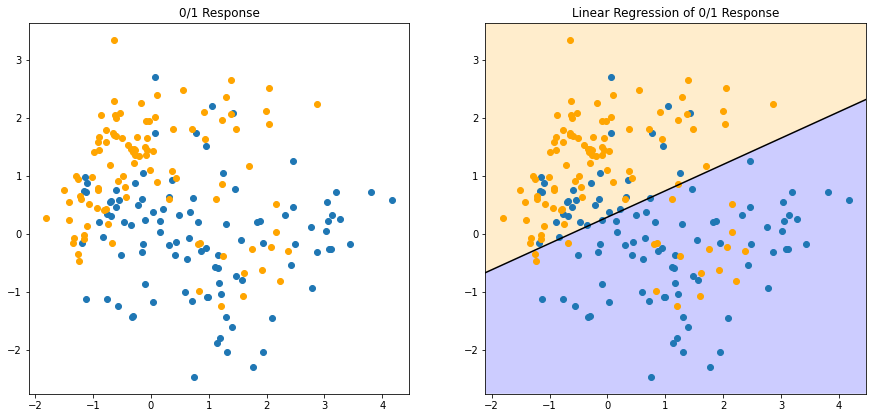

In [27]:
"""FIGURE 2.1. A classification example in 2D."""
# Plot for OLS
ax2 = fig.add_subplot(2, 2, 2)

ax2.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax2.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')

# OLS line for y_hat = X^T\beta_hat = 0.5
ols_line_y_min = (.5 - ols_beta[0] - plot_x_min*ols_beta[1])/ols_beta[2]
ols_line_y_max = (.5 - ols_beta[0] - plot_x_max*ols_beta[1])/ols_beta[2]
ax2.plot([plot_x_min, plot_x_max], [ols_line_y_min, ols_line_y_max], color='black')

# https://matplotlib.org/examples/pylab_examples/fill_between_demo.html
ax2.fill_between([plot_x_min, plot_x_max], plot_y_min, [ols_line_y_min, ols_line_y_max],
                facecolor='blue', alpha=.2)
ax2.fill_between([plot_x_min, plot_x_max], [ols_line_y_min, ols_line_y_max], plot_y_max,
                facecolor='orange', alpha=.2)
ax2.set_title('Linear Regression of 0/1 Response')
ax2.set_xlim((plot_x_min, plot_x_max))
ax2.set_ylim((plot_y_min, plot_y_max))
fig

In [13]:
ols_line_y_min

-0.6629370145399807

In [14]:
ols_line_y_max

2.321034034948018

### Where the data came from?

We see that for these data there are several misclassifications on both sides of the decision boundary. Perhaps our linear model is too rigid -- or are such errors unavoidable? Remember that these are errors on the training data itself, and we have not said where the constructed came from (although this notebook already exposed the oracle). Consider the two possible scenarios:
* $\text{Scenario 1}$: The training data in each class were generated from bivariate Gaussian distributions with uncorrelated components and different means.
* $\text{Scenario 2}$: The training data in each class came from a mixture of 10 low-variance Gaussian distributions, with individual means themselves distributed as Gaussian.

A mixture of Gaussians is best described in terms of the generative model.
* One first generates a discrete variable that determines which of the component Gaussians to use,
* and then generates an observation from the chosen density.

In the case of one Gaussian per class, we will see in Chapter 4 that a linear decision boundary is the best one can do, and that our estimate is almost optimal. The region of overlap is inevitable, and future data to be predicted will be plagued by this overlap as well.

## $\S$ 2.3.2 Nearest-Neighbor Methods

Now we look at another classification and regression procedure that is in some sense at the opposite end of the spectrum to the linear model, and far better suited to the second scenario.

> Nearest-neighbor methods use those observations in the training set $\mathcal{T}$ closest in input space to $x$ to form $\hat{Y}$.

The kNN fit for $\hat{Y}$ is defined as follows:

\begin{equation}
\hat{Y}(x) = \frac{1}{k}\sum_{x_i\in N_k(x)} y_i,
\end{equation}

where $N_k(x)$ is the neighborhood of $x$ defined by the $k$ closest points $x_i$ in the training sample. Closeness implies a metric, which for the moment we assume is Euclidean distance.

> So, in other words, we find the $k$ observations with $x_i$ closest to $x$ in input space, and average their responses.

In FIGURE 2.2 we use the same training data, and use 15NN averaging of the binary coded response as the method of fitting. Thus $\hat{Y}$ is the proportion of $\textsf{ORANGE}$s in the neighborhood, and so assigning class $\text{ORANGE}$ to $\hat{G}$ if $\hat{Y} > 0.5$ amounts to a majority vote in the neighborhood.

We see that the decision boundaries that separate the $\textsf{BLUE}$ from the $\textsf{ORANGE}$ regions are far more irregular, and respond to local clusters where one class dominates.

In [4]:
# K-nearest neighbors
def knn(k: int, point, data_x, data_y) -> float:
    if not isinstance(point, np.ndarray):
        point = np.array(point)
    distances = [(sum((x - point)**2), y) for x, y in zip(data_x, data_y)]
    distances.sort()
    return sum(y for _, y in distances[:k])/k

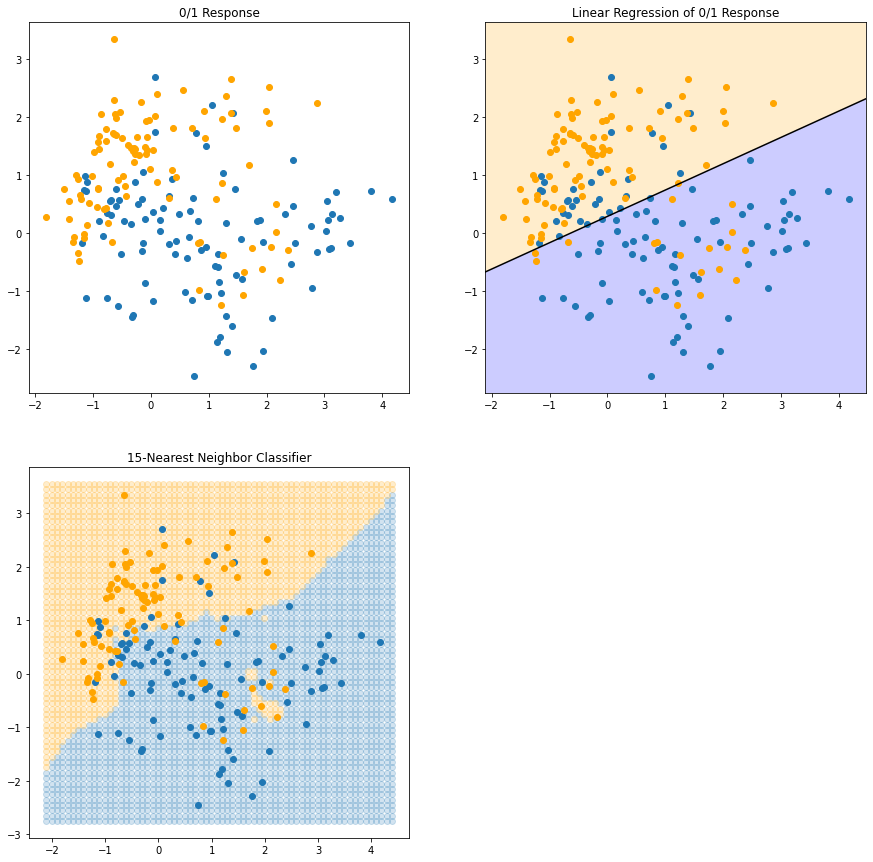

In [28]:
"""FIGURE 2.2. 15-nearest-neighbor method"""
# Compute KNN for k = 15
knn_grid = np.array([(i, j)
                     for i in np.arange(plot_x_min, plot_x_max, .1)
                     for j in np.arange(plot_y_min, plot_y_max, .1)])

# knn15_result contains the x coordinate，y coordinate of point(x,y) and knn value
knn15_result = np.array([
    (i, j, knn(15, (i, j), data_x, vec_y))
    for i, j in knn_grid
])

# Plot for KNN with k = 15

knn15_blue = np.array([
    (i, j)
    for i, j, knn15 in knn15_result
    if knn15 < .5
])
knn15_orange = np.array([
    (i, j)
    for i, j, knn15 in knn15_result
    if knn15 > .5
])
ax3 = fig.add_subplot(2, 2, 3)
# KNN areas
ax3.plot(knn15_blue[:, 0], knn15_blue[:, 1], 'o', alpha=.2)
ax3.plot(knn15_orange[:, 0], knn15_orange[:, 1], 'o', color='orange', alpha=.2)
# Original data
ax3.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax3.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax3.set_title('15-Nearest Neighbor Classifier')
fig

In [21]:
knn_grid

array([[-2.10742982, -2.75163406],
       [-2.10742982, -2.65163406],
       [-2.10742982, -2.55163406],
       ...,
       [ 4.39257018,  3.34836594],
       [ 4.39257018,  3.44836594],
       [ 4.39257018,  3.54836594]])

In [22]:
knn15_result

array([[-2.10742982, -2.75163406,  0.33333333],
       [-2.10742982, -2.65163406,  0.4       ],
       [-2.10742982, -2.55163406,  0.4       ],
       ...,
       [ 4.39257018,  3.34836594,  0.46666667],
       [ 4.39257018,  3.44836594,  0.53333333],
       [ 4.39257018,  3.54836594,  0.53333333]])

FIGURE 2.3 shows the results for 1NN classification: $\hat{Y} is assigned the value $y_l$ of the closest point $x_l$ to $x$ in the training data. In this case the regions of classification can be computed relatively easily, and correspond to a _Voronoi tessellation_ of the training data. 

The decision boundary is even more irregular than before.

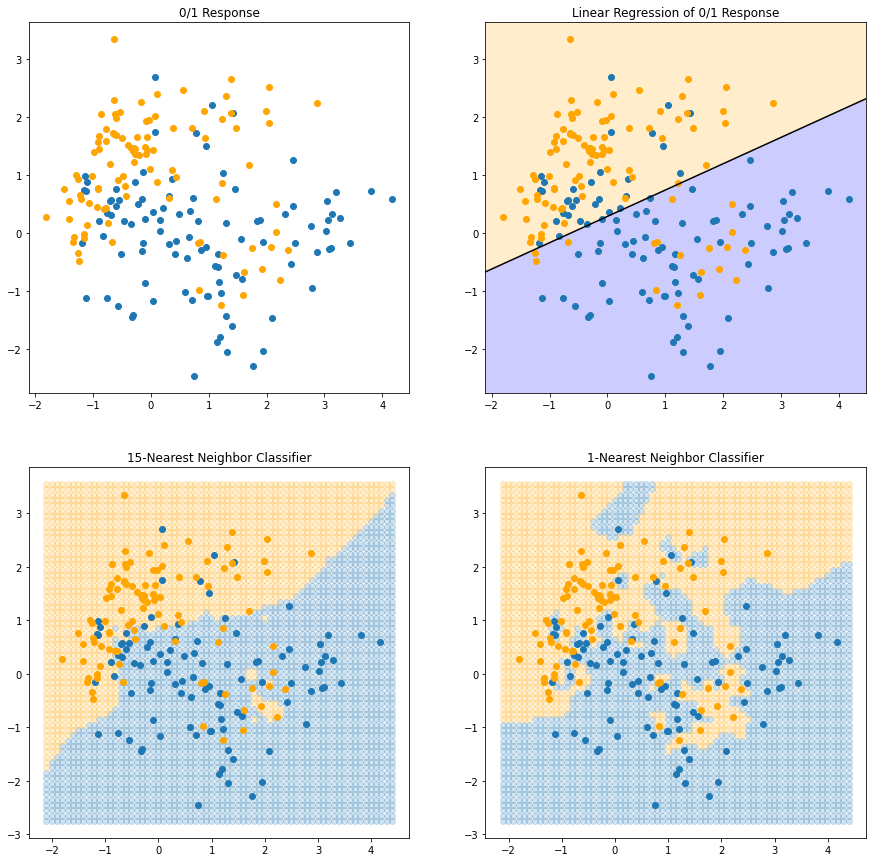

In [29]:
"""FIGURE 2.3. 1-nearest-neighbor method"""
# Compute KNN for k = 1
knn1_result = np.array([
    (i, j, knn(1, (i, j), data_x, vec_y))
    for i, j in knn_grid
])

knn1_blue = np.array([
    (i, j)
    for i, j, knn1 in knn1_result
    if knn1 < .5
])
knn1_orange = np.array([
    (i, j)
    for i, j, knn1 in knn1_result
    if knn1 > .5
])

# Plot for KNN with k = 1
ax4 = fig.add_subplot(2, 2, 4)
# KNN areas
ax4.plot(knn1_blue[:, 0], knn1_blue[:, 1], 'o', alpha=.2)
ax4.plot(knn1_orange[:, 0], knn1_orange[:, 1], 'o', color='orange', alpha=.2)
# Original data
ax4.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax4.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax4.set_title('1-Nearest Neighbor Classifier')
fig

The method of kNN averaging is defined in exactly the same way for regression of a quantitative output $Y$, although $k=1$ would be an unlikely choice.

### Do not satisfy with the training results

With 15NN, We see that far fewer training observations are misclassfied than the linear model fit. This should not give us too much comfort, though, since using 1NN  _none_ of the training data are misclassified.

A little thought suggests that for kNN fits, the error on the training data should be approximately an increasing function of $k$, and will always be 0 for $k=1$.

An independent test set would give us a more satisfactory means for comparing the different methods.

### Effective number of parameters

It appears that kNN fits have a single parameter, the number of neighbors $k$, compared to the $p$ parameters in least-squares fit. Although this is the case, we will see that the _effective_ number of parameters of kNN is $N/k$ and is generally bigger than $p$, and decreases with increasing $k$.

To get an idea of why, note that if the neighborhoods were nonoverlapping, there would be $N/k$ neighborhoods and we fit one parameter (a mean) in each neighborhood.

### Do not appreciate the training errors

It is also clear that we cannot use sum-of-squared errors on the training set as a criterion for picking $k$, since we would always pick $k=1$! It would seem that kNN methods would be more appropriate for the mixture Scenario 2, while for Scenario 1 the decision boundaries for kNN would be unnecessarily noisy.

## $\S$ 2.3.3. From Least Squares to Nearest Neighbors

A large subset of the most popular techniques in use today are variants of these two simple procedures. In facti 1NN, the simplest of all, captures a large percentage of the market for low-dimensional problems.

The following list describes some ways in which these simple procedures have been enhanced:
* Kernel methods use weights that decrease smoothly to zero with distance from the target point, rather than the effectve 0/1 weights used by kNN.
* In high-dimensional spaces the distance kernels are modified to emphasize some variable more than others.
* Local regression fits linear models by locally weighted least squares, rather than fitting constants locally.
* Linear models fit to a basis expansion of the original inputs allow arbitrarilly complex models.
* Projection pursuit and neural network models consist of sums of nonlinearly transfromed linear models.

# $\S$ 2.4. Statistical Decision Theory

In this section we develop a small amount of theory that provides a framework for developing models. We first consider the case of a quantitative output, and place outselves in the world of random variables nad probability spaces.

### Definitions

Let
* $X\in\mathbb{R}^p$ denote a real valued random input vector, and
* $Y\in\mathbb{R}$ a real valued random output variable,
* with joint distribution $\text{Pr}(X,Y)$.

We seek a function $f(X)$ for predicting $Y$  given values of the input $X$.

#### Loss
This Theory requires a _loss function_ $L(Y, f(X))$ for penalizing errors in prediction, and by for the most common and convenient is _squared error loss_:

\begin{equation}
L(Y, f(X)) = (Y-f(X))^2.
\end{equation}

#### Expected prediction error
This leads us to a criterion for choosing $f$ the expected (squared) prediction error:

\begin{align}
\text{EPE}(f) &= \text{E}(Y-f(X))^2\\
&= \int\left(y-f(x)\right)^2\text{Pr}(dx,dy)\\
&= \int\left(y-f(x)\right)^2p(x,y)dxdy\\
&= \int_x\int_y\left(y-f(x)\right)^2p(x,y)dxdy\\
&= \int_x\int_y\left(y-f(x)\right)^2p(y|x)p(x)dxdy\\
&= \int_x\Biggl(\int_y\left(y-f(x)\right)^2p(y|x)dy\Biggr)p(x)dx\\
&= \int_x\Biggl(E_{Y|X}([Y-f(X)]^2|X=x)\Biggr)p(x)dx\\
&= E_XE_{Y|X}([Y-f(X)]^2|X=x),
\end{align}

By conditioning on $X$, we can write EPE as

\begin{equation}
\text{EPE}(f) = \text{E}_X\text{E}_{Y|X}\left(\left[Y-f(X)\right]^2|X=x\right)
\end{equation}

and we see that it suffices to minimize EPE pointwise:

\begin{equation}
f(x) = \arg\min_c\text{E}_{Y|X}\left(\left[Y-c\right]^2|X=x\right)
\end{equation}

Where $argmin$ is argument of the minimum. The simplest example is $argmin_xf(x)$ is the value of $x$ for which $f(x)$ attains it's minimum. 

Since 
\begin{align}
E(E(X|Y))&=\int E(X|Y=y)f_Y(y)dy\\
&=\iint xf_{X|Y}(x|y)dxf_Y(y)dy\\
&=\iint xf_{X|Y}(x|y)f_Y(y)dxdy\\
&=\iint xf_{XY}(x,y)dxdy\\
&=\int x\Bigl(\int f_{XY}(x,y)dy\Bigr)dx\\
&=\int xf_X(x)dx\\
&=E(X)
\end{align}
and then 
\begin{align}
E\Bigl((Y-f(X))^2|X\Bigr)&=E\Biggl(\Bigl([Y-E(Y|X)]+[E(Y|X)-f(X)]\Bigr)^2|X\Biggr)\\
&=E\Biggl(\Bigl([Y-E(Y|X)]\Bigr)^2|X\Biggr)+E\Biggl(\Bigl([E(Y|X)-f(X)]\Bigr)^2|X\Biggr)+2E\Biggl(\Bigl([Y-E(Y|X)][E(Y|X)-f(X)]\Bigr)|X\Biggr)\\
&=E\Biggl(\Bigl([Y-E(Y|X)]\Bigr)^2|X\Biggr)+E\Biggl(\Bigl([E(Y|X)-f(X)]\Bigr)^2|X\Biggr)+2\Biggl(\Bigl([E(Y|X)-f(X)]\Bigr)E\Bigl([Y-E(Y|X)]\Bigr)|X\Biggr)\\
&(\text{since } [E(Y|X)-f(X)] \text{ is constant given } X)\\
&\text{and since }E\Bigl([Y-E(Y|X)]\Bigr)=E(Y)-E(E(Y|X))=E(Y)-E(Y)=0\\
&=E\Biggl(\Bigl([Y-E(Y|X)]\Bigr)^2|X\Biggr)+E\Biggl(\Bigl([E(Y|X)-f(X)]\Bigr)^2|X\Biggr)\\
&\ge E\Biggl(\Bigl([Y-E(Y|X)]\Bigr)^2|X\Biggr)
\end{align}

When $E(Y|X)-f(X)=0\\
E\Bigl((Y-f(X))^2|X\Bigr)=E\Biggl(\Bigl([Y-E(Y|X)]\Bigr)^2|X\Biggr)$
#### Regression function
The solution is the conditional expectation a.k.a. the _regression_ function:

\begin{equation}
f(x) = \text{E}\left(Y|X=x\right)
\end{equation}

> Thus the best prediction of $Y$ at any point $X=x$ is the conditional mean, when best is measured by average squared error.

### Conclusions first

Both KNN and least squares will end up approximating conditional expectations by averages. But they differ dramatically in terms of model assumptions:
* Least squares assumes $f(x)$ is well approximated by a globally linear function.
* $k$-nearest neighbors assumes $f(x)$ is well approximated by a locally constant function.
Although the latter seems more palatable, we will see below that we may pay a price for this flexibility.

### The light and shadows of kNN

The kNN attempts to directly implement this recipe using the training data:

\begin{equation}
\hat{f}(x) = \text{Ave}\left(y_i|x_i\in N_k(x)\right),
\end{equation}

where
* "$\text{Ave}$" denotes average, and
* $N_k(x)$ is the neighborhood containing the $k$ points in $\mathcal{T}$ closest to $x$.

Two approximations are happening here:
* Expectation is approximated by averaging over sample data;
* conditioning at a point is relaxed to conditioning on some region "close" to the target point.

For large training sample size $N$, the points in the neighborhood are likely to be close to $x$, and as $k$ gets large the average will get more stable. In fact, under mild regularity conditions on the joint probability distribution $\text{Pr}(X,Y)$, one can show that

\begin{equation}
\hat{f}(x)\rightarrow\text{E}(Y|X=x)\text{ as }N,k\rightarrow\infty\text{ s.t. }k/N\rightarrow0
\end{equation}

#### Isn't it perfect?

In light of this, why look further, since it seems we have a universal approximator?
* We often do not have very large samples.  
  Linear models can usually get a more stable estimate than kNN, provided the structured model is appropriate (although such knowledge has to be learned from the data as well).
* Curse of dimensionality.  
  As the dimension $p$ gets large, so does the metric size of the $k$-nearest neighborhood. So settling for kNN as a surrogate for conditioning will fail us miserably.  
  The convergence above still holds, but the _rate_ of convergence decreases as the dimension increases.

### Model-based approach for linear regression

How does linear regression fit into this framework? The simplest explanation is that one assumes that the regression function $f(x)$ is approximately linear in its arguments:

\begin{equation}
f(x)\approx x^T\beta.
\end{equation}

This is a model-based approach -- we specify a model for the regression function. 

Plugging this linear model for $f(x)$ into EPE and differentiating, we can solve for $\beta$ theoretically:

\begin{equation}
EPE(\beta)=\int(y-x^T\beta)^2P(dx,dy)
\end{equation}

Then
\begin{equation}
\frac{\partial{EPE}}{\partial{\beta}}=\int2(y-x^T\beta)(-1)xP(dx,dy)\\
=-2\int(y-x^T\beta)xP(dx,dy)\\
\text{since } y-x^T\beta \text{ are scalars }\\
=-2\int(yx-xx^T\beta)P(dx,dy)\\
\end{equation}

Let
\begin{equation}
\frac{\partial{EPE}}{\partial{\beta}}=0
\end{equation}
Then 
\begin{equation}
\int(yx-xx^T\beta)P(dx,dy)=E(yx)-E(xx^T\beta)=E(yx)- E(xx^T)\beta=0
\end{equation}
Then
\begin{equation}
\beta = E(xx^T)^{-1}E(yx)
\end{equation}

\begin{equation}
\beta = \left[\text{E}\left(XX^T\right)\right]^{-1}\text{E}(XY)
\end{equation}

Note we have _not_ conditioned on $X$; rather we have used out knowledge of the functional relationship to _pool_ over values of $X$. The least squares solution

\begin{equation}
\hat\beta = \left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{y}
\end{equation}

amounts to replacing the expectation in the theoretical solution by averages over the training data.

### kNN vs. least squares

So both kNN and least squares end up approximating conditional expectations by averages. But they differ dramatically in terms of model assumptions:
* Least squares assumes $f(x)$ is well approximated by a globally linear function.
* kNN assumes $f(x)$ is well approximated by a locally constant function.

Although the latter seems more palatable, we have already seen that we may pay a price for this flexibility.

### Additive models (Brief on modern techniques)

Many of the more modern techniques described in this book are model based, although far more flexible than the rigid linear model.

For example, additive models assume that

\begin{equation}
f(X) = \sum_{j=1}^p f_j(X_j).
\end{equation}

This retains the additivity of the linear model, but each coordinate function $f_j$ is arbitrary. It turns out that the optimal estimate for the additive model uses techniques such as kNN to approximate _univariate_ conditional expectations _simultaneously_ for each of the coordinate functions.

Thus the problems of estimating a conditional expectation in high dimensions are swept away in this case by imposing some (often unrealistic) model assumptions, in this case additivity.

### Are we happy with $L_2$ loss? Yes, so far.

If we replace the $L_2$ loss function with the $L_1$:

\begin{equation}
E\left| Y - f(X) \right|,
\end{equation}

the solution in this case is the conditional median,

\begin{equation}
\hat{f}(x) = \text{median}(Y|X=x),
\end{equation}

which is a different measure of location, and its estimates are more robust than those for the conditional mean.

$L_1$ criteria have discontinuities in their derivatives, which have hindered their widespread use. Other more resistant loss functions will be mentioned in later chapters, but squared error is analytically convenient and the most popular.

### Bayes classifier: For a categorical output with 0-1 loss function

The same paradigm works when the output is a categorical variale $G$, except we need a different loss function for penalizing prediction errors. An estimate $\hat{G}$ will assume values in $\mathcal{G}$, the set of possible classes.

Our loss function can be represented by $K\times K$ matrix $\mathbf{L}$, where $K=\text{card}(\mathcal{G})$. $\mathbf{L}$ will be zero on the diagonal and nonnegative elsewhere, representing the price paid for misclassifying $\mathcal{G}_k$ as $\mathcal{G}_l$;

\begin{equation}
\mathbf{L} = \begin{bmatrix}
0 & L(\mathcal{G}_1, \mathcal{G}_2) & \cdots & L(\mathcal{G}_1, \mathcal{G}_K) \\
L(\mathcal{G}_2, \mathcal{G}_1) & 0 & \cdots & L(\mathcal{G}_2, \mathcal{G}_K) \\
\vdots & \vdots & \ddots & \vdots \\
L(\mathcal{G}_K, \mathcal{G}_1) & L(\mathcal{G}_K, \mathcal{G}_2) & \cdots & 0
\end{bmatrix}
\end{equation}

The expected prediction error is

\begin{equation}
\text{EPE} = \text{E}\left[L(G, \hat{G}(X)\right],
\end{equation}

where the expectation is taken w.r.t. the joint distribution $\text{Pr}(G, X)$.

Again we condition, and can write EPE as

\begin{equation}
\text{EPE} = \text{E}_X\sum^K_{k=1}L\left(\mathcal{G}_k, \hat{G}(X)\right)\text{Pr}\left(\mathcal{G}_k|X\right)
\end{equation}

and again it suffices to minimize EPE pointwise:

\begin{equation}
\hat{G}(x) = \arg\min_{g\in\mathcal{G}}\sum^K_{k=1} L\left(\mathcal{G}_k,g\right)\text{Pr}\left(\mathcal{G}_k|X=x\right)
\end{equation}

#### 0-1 loss for Bayes classifier

Most often we use the _zero-one_ loss function, where all misclassifications are charged a single unit, i.e.,

\begin{equation}
L(k,l) = \begin{cases}
0\text{ if }k = l,\\
1\text{ otherwise}.
\end{cases}
\end{equation}

With the 0-1 loss function this simplifies to

\begin{align}
\hat{G}(x) &= \arg\min_{g\in\mathcal{G}} \left[1 - \text{Pr}(g|X=x)\right]\\
&= \mathcal{G}_k \text{ if Pr}\left(\mathcal{G}_k|X=x\right) = \max_{g\in\mathcal{G}}\text{Pr}(g|X=x)
\end{align}

This reasonable solution is known as the _Bayes classifier_, and says that we classify to the most probable class, using the conditional (discrete) distribution $\text{Pr}(G|X)$. FIGURE 2.5 shows the Bayes-optimal decision boundary for our simulation example. The error rate of the Bayes classifier is called the _Bayes rate_.

In [8]:
%matplotlib inline
import random
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt

In [16]:
"""FIGURE 2.5. The optimal Bayes decision boundary for the simulation example.
Since the generating density is known for each class, this decision boundary can be
calculated exactly."""
sample_size = 100
# Parameters for mean distributions
mean_blue = [1, 0]
mean_orange = [0, 1]
mean_cov = np.eye(2)
mean_size = 10

# Additional parameters for blue and orange distributions
sample_cov = np.eye(2)/5

# Generate mean components for blue and orange (10 means for each)
sample_blue_mean = np.random.multivariate_normal(mean_blue, mean_cov, mean_size)
sample_orange_mean = np.random.multivariate_normal(mean_orange, mean_cov, mean_size)

# Generate blue points
sample_blue = np.array([
    np.random.multivariate_normal(sample_blue_mean[random.randint(0, 9)], sample_cov)
    for _ in range(sample_size)
])
y_blue = np.zeros(sample_size)

# Generate orange points
sample_orange = np.array([
    np.random.multivariate_normal(sample_orange_mean[random.randint(0, 9)], sample_cov)
    for _ in range(sample_size)
])
y_orange = np.ones(sample_size)

data_x = np.concatenate((sample_blue, sample_orange), axis=0)
data_y = np.concatenate((y_blue, y_orange)) 

In [19]:
def density_blue(arr:np.ndarray)->np.ndarray:
    densities = np.array([
        scipy.stats.multivariate_normal.pdf(arr, mean=m, cov=mean_cov)
        for m in sample_blue_mean
    ])
    return densities.mean(axis=0)


def density_orange(arr:np.ndarray)->np.ndarray:
    densities = np.array([
        scipy.stats.multivariate_normal.pdf(arr, mean=m, cov=mean_cov)
        for m in sample_orange_mean
    ])
    return densities.mean(axis=0)

In [20]:
min_x = data_x.min(axis=0)
max_x = data_x.max(axis=0)
print(min_x, max_x)
arr = np.array([(i, j)
                   for i in np.linspace(min_x[0]-.1, max_x[0]+.1, 100)
                   for j in np.linspace(min_x[1]-.1, max_x[1]+.1, 100)])
proba_blue = density_blue(arr)
proba_orange = density_orange(arr)

[-2.53219024 -2.30121419] [2.50789865 2.91277445]


In [21]:
arr

array([[-2.63219024, -2.40121419],
       [-2.63219024, -2.34652744],
       [-2.63219024, -2.29184069],
       ...,
       [ 2.60789865,  2.90340094],
       [ 2.60789865,  2.9580877 ],
       [ 2.60789865,  3.01277445]])

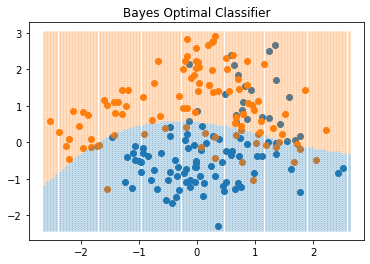

In [22]:
# Plot
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
# Original data
ax.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='C1')
# Bayes classifier
mask_blue = proba_blue > proba_orange
mask_orange = ~mask_blue
ax.plot(arr[mask_blue, 0], arr[mask_blue, 1], 'o',
        markersize=2, color='C0', alpha=.2)
ax.plot(arr[mask_orange, 0], arr[mask_orange, 1], 'o',
        markersize=2, color='C1', alpha=.2)
ax.set_title('Bayes Optimal Classifier')
plt.show()

### KNN and Bayes classifier

Again we see that the kNN classifier directly approximates this solution -- a majority vote in a nearest neighborhood amounts to exactly this, except that
* conditional probability at a point is relaxed to conditional probability within a neighborhood of a point,
* and probabilities are estimated by training-sample proportions.

### From two-class to $K$-class
Suppose for a two-class problem we had taken the dummy-variable approach and coded $G$ via a binary $Y$, followed by squared error loss estimation. Then

\begin{equation}
\hat{f}(X) = \text{E}(Y|X) = \text{Pr}(G=\mathcal{G}_1|X)
\end{equation}

if $\mathcal{G}_1$ corresponded to $Y=1$.

Likewise for a $K$-class problem,

\begin{equation}
\text{E}(Y_k|X) = \text{Pr}(G=\mathcal{G}_k|X).
\end{equation}

> This shows that our dummy-variable regression procedure, followed by classification to the largest fitted value, is another way of representing the Bayes classifier.

Although this theory is exact, in practice problems can occur, depending on the regression model used. For example, when linear regression is used, $\hat{f}(X)$ need not be positive, and we might be suspicious about using it as an estimate of a probability. We will discuss a variety of approaches to modeling $\text{Pr}(G|X)$ in Chapter 4.

# $\S$ 2.5. Local Methods in High Dimensions

We have examined two learning techniques for prediction so far;
* the stable but biased linear model and
* the less stable but apparently less biased class of kNN estimates.

It would seem that with a reasonably large set of training data, we could always approximate the theoretically optimal conditional expectation by kNN averaging, since we should be able to find a fairly large neighborhood of observations close to any $x$ and average them.

### The curse of dimensionality (Bellman, 1961)

This approach and our intuition breaks down in high dimensions, and the phenomenon is commonly referred to as the _curse of dimensionality_ (Bellman, 1961). There are many manifestations of this problem, and we will examine a few here.

### The first example: Unit hypercube

Consider the nearest-neighbor procedure for inputs uniformly distributed in a p-dimensional unit hypercube. Suppose we send out a hypercubical neighborhood about a target point to capture a fraction $r$ of the observations. Since this corresponds to a fraction $r$ of the unit volume, the expected edge length will be 

\begin{equation}
e_p(r) = r^{1/p}.
\end{equation}

Note that $e_{10}(.01) = 0.63$ and $e_{10}(.1) = .80$, while the entire range for each input is only 1.0. Soto capture 1% or 10% of the data to form a local average, we must cover 63% or 80% of the range of each input variable. Such neighborhoods are no longer "local".

Reducing $r$ dramatically does not help much either, since the fewer observations we average, the higher is the variance of our fit.

In [23]:
%matplotlib inline
import math
import random
import numpy as np
import matplotlib.pyplot as plt

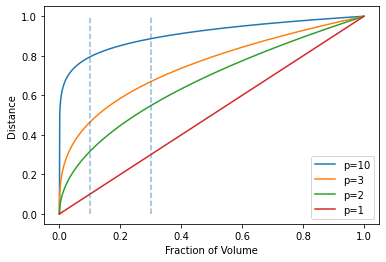

In [24]:
"""FIGURE 2.6. (right panel) The unit hypercube example"""
fraction_of_volume = np.arange(0, 1, 0.001)
edge_length_p1 = fraction_of_volume
edge_length_p2 = fraction_of_volume**.5
edge_length_p3 = fraction_of_volume**(1/3)
edge_length_p10 = fraction_of_volume**.1

fig1 = plt.figure(1)
ax11 = fig1.add_subplot(1, 1, 1)
ax11.plot(fraction_of_volume, edge_length_p10, label='p=10')
ax11.plot(fraction_of_volume, edge_length_p3, label='p=3')
ax11.plot(fraction_of_volume, edge_length_p2, label='p=2')
ax11.plot(fraction_of_volume, edge_length_p1, label='p=1')
ax11.set_xlabel('Fraction of Volume')
ax11.set_ylabel('Distance')
ax11.legend()
ax11.plot([.1, .1], [0, 1], '--', color='C0', alpha=.5)
ax11.plot([.3, .3], [0, 1], '--', color='C0', alpha=.5)
plt.show()

### The second example: Unit ball

In high dimensions all sample points are close to an edge of the sample.

Consider $N$ data points uniformly distributed in a $p$-dimensional unit ball centered at the origin. And consider a nearest-neighbor estimate at the origin. The median distance from the orign to the closest data point is given by the expression (Exercise 2.3)

\begin{equation}
d(p,N) = \left(1-\frac{1}{2}^{1/N}\right)^{1/p}.
\end{equation}

A more complicated expression exists for the mean distance to the closest point.

For $N=500, p=10$, $d(p,N)\approx0.52$, more than half way to the boundary. Hence most data points are close to the boundary of the sample space than to any other data point.

Why is this a problem? Prediction is much more difficult near the edges of the training sample. One must extrapolate from neighboring sample points rather than interpolate between them.

### The third example: Sampling density

Another manifestiation of the curse is that the sampling density is proportional to $N^{1/p}$.

If $N_1=100$ represents a dense sample for a single input problem, then $N_{10}=100^{10}$ is the sample size required for the same sampling density with 10 inputs. Thus in high dimensions all feasible training samples sparsely populate the input space.

### The fourth example: Bias-variance decomposition

Let us construct another uniform example. Suppose
* we have 1000 training examples $x_i$ generated uniformly on $[-1,1]^p$, and
* the true relationship between $X$ and $Y$ is  

  \begin{equation}
  Y = f(X) = e^{-8\|X\|^2},
  \end{equation}
  
  without any measurement error.
* We use the 1NN rule to predict $y_0$ at the test-point $x_0=0$.

Denote the training set by $\mathcal{T}$. We can compute the expected prediction error at $x_0$ for our procedure, averaging over all such samples of size 1000. Since the problem is deterministic, this is the mean squared error (MSE) for estimating $f(0)$.

\begin{align}
\text{MSE}(x_0) &= \text{E}_\mathcal{T}\left[f(x_0)-\hat{y}_0\right]^2 \\
&= \text{E}_\mathcal{T}\left[f(x_0) -\text{E}_\mathcal{T}(\hat{y}_0) + \text{E}_\mathcal{T}(\hat{y}_0)-\hat{y}_0\right]^2 \\
&= \text{E}_\mathcal{T}\left[\hat{y}_0 - \text{E}_\mathcal{T}(\hat{y}_0)\right]^2 + \left[\text{E}_\mathcal{T}(\hat{y}_0)-f(x_0)\right]^2 + 2\left[\text{E}_\mathcal{T}(\hat{y}_0)-f(x_0)\right]\text{E}_\mathcal{T}\left[\hat{y}_0 - \text{E}_\mathcal{T}(\hat{y}_0)\right]\\
&= \text{E}_\mathcal{T}\left[\hat{y}_0 - \text{E}_\mathcal{T}(\hat{y}_0)\right]^2 + \left[\text{E}_\mathcal{T}(\hat{y}_0)-f(x_0)\right]^2 \\
&= \text{Var}_\mathcal{T}(\hat{y}_0) + \text{Bias}^2(\hat{y}_0)
\end{align}

We have broken down the MSE into two components that will become familiar as we proceed: Variance and squared bias. Such a decomposition is always possible and often useful, and is known as the _bias-variance decomposition_.

FIGURE 2.7 illustrates the setup. Unless the nearest neighbor is at 0, $\hat{y}$ will be biased downward. The variance  is due to the sampling variance of the 1NN.

In [2]:
np.array([random.uniform(-1, 1) for _ in range(100)])

array([ 0.52362402, -0.94160915,  0.76358392, -0.92365576, -0.30958527,
        0.41281719, -0.7303279 , -0.91000641,  0.45042398,  0.65164906,
        0.6156556 ,  0.43792673,  0.60248841, -0.83713385, -0.26846477,
        0.35379219, -0.5860781 , -0.84750126,  0.15911063,  0.63183339,
        0.47572948,  0.23940263, -0.13400333, -0.6860668 ,  0.22164816,
        0.64684125, -0.47198284, -0.92006244, -0.24139513, -0.85121428,
       -0.98214255,  0.87564502, -0.96080989, -0.88877688,  0.94252343,
       -0.03999984, -0.17849397,  0.90958777,  0.06223157, -0.47722939,
        0.80215919, -0.43945665, -0.59054645,  0.69098503,  0.8374996 ,
       -0.01377477, -0.7367969 , -0.08373888,  0.97429187,  0.66285725,
       -0.10196032,  0.52860923,  0.00819558, -0.28304599,  0.73095748,
        0.26700299, -0.53518844, -0.43642706, -0.47041087, -0.41063947,
       -0.63719431,  0.59294264, -0.61269841,  0.22890798,  0.90696006,
       -0.11469428,  0.54643137,  0.09056606,  0.62173869, -0.63

In [9]:
 np.array([
     [random.uniform(-1, 1) for _ in range(2)] for _ in range(10)])

array([[-0.48601796, -0.44968368],
       [-0.77970785,  0.89003972],
       [-0.79092711,  0.61238668],
       [ 0.67055626,  0.44152098],
       [ 0.66777796, -0.89992495],
       [-0.5107149 ,  0.13814159],
       [-0.48246821, -0.55975761],
       [ 0.51114079,  0.9236153 ],
       [-0.43424228,  0.7123616 ],
       [-0.57744428,  0.47452944]])

In [10]:
"""FIGURE 2.7. (bottom panels) Bias-variance decomposition example.
Given the dimension p, 100 simulations are done and the following steps are
taken for each simulation.
1. Generate data of size 1000 from [-1, 1]^p
2. Grap the nearest neighbor x of 0 and calculate the distance, i.e., norm
3. Calculate y=f(x) and the variance and the squared bias for simulation
of size 100.
"""
import math
def generate_data(p: int, n: int) ->np.ndarray:
    if p == 1:
        return np.array([random.uniform(-1, 1) for _ in range(n)])
    return np.array([
        [random.uniform(-1, 1) for _ in range(p)]
        for _ in range(n)
    ])


def f(p: int, x: np.ndarray) ->float:
    if p == 1:
        return math.exp(-8*(x**2))
    return math.exp(-8*sum(xi*xi for xi in x))

# np.linalg.norm to return one of eight different matrix norms, or one of an infinite number of vector norms
# ord=2 is the Order of the norm
# axis=1 it specifies the axis of x along which to compute the vector norms, 0 for columns; 1 for rows.
def simulate(p: int, nsample:int, nsim: int) ->dict:
    res = {'average_distance': 0}
    sum_y = 0
    sum_y_square = 0
    for _ in range(nsim):
        data = generate_data(p, nsample)
        if p == 1:
            data_norm = np.abs(data)
        else:
            data_norm = np.linalg.norm(data, ord=2, axis=1)
        nearest_index = data_norm.argmin()
        nearest_x, nearest_distance = data[nearest_index], data_norm[nearest_index]
        nearest_y = f(p, nearest_x)
        sum_y += nearest_y
        sum_y_square += nearest_y*nearest_y
        res['average_distance'] += nearest_distance
    average_y = sum_y/nsim
    res['average_distance'] /= nsim
    res['variance'] = sum_y_square/nsim - average_y*average_y
    res['squared_bias'] = (1-average_y)*(1-average_y)
    return res

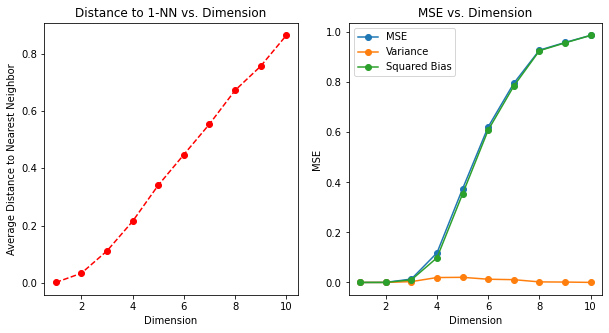

In [19]:
nsim = 100
data = {p: simulate(p, 1000, nsim) for p in range(1, 11)}
dimension = list(data.keys())
average_distance = [d['average_distance'] for p, d in data.items()]
variance = np.array([d['variance'] for p, d in data.items()])
squared_bias = np.array([d['squared_bias'] for p, d in data.items()])
mse = variance + squared_bias

fig2 = plt.figure(2, figsize=(10, 5))
ax21 = fig2.add_subplot(1, 2, 1)
ax21.set_title('Distance to 1-NN vs. Dimension')
ax21.plot(dimension, average_distance, 'ro--')
ax21.set_xlabel('Dimension')
ax21.set_ylabel('Average Distance to Nearest Neighbor')

ax22 = fig2.add_subplot(1, 2, 2)
ax22.set_title('MSE vs. Dimension')
ax22.plot(dimension, mse, 'o-', label='MSE')
ax22.plot(dimension, variance, 'o-', label='Variance')
ax22.plot(dimension, squared_bias, 'o-', label='Squared Bias')
ax22.set_xlabel('Dimension')
ax22.set_ylabel('MSE')
ax22.legend()
plt.savefig("savefig.pdf", dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype='letter', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        metadata=None)
plt.show()

The Frobenius norm is given by:

$||A||_F = [\sum_{i,j} abs(a_{i,j})^2]^{1/2}$

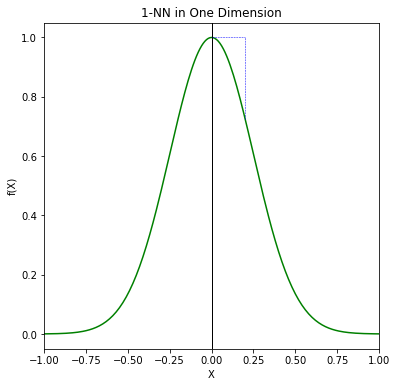

In [14]:
#plot the target function (no noise)

import matplotlib.pyplot as plt
import math
import random
import numpy as np

def f(p: int, x: np.ndarray) ->float:
    if p == 1:
        return math.exp(-8*(x**2))
    return math.exp(-8*sum(xi*xi for xi in x))
x_cords = np.linspace(-1.0, 1.0, 201)
y_cords = [f(1, x) for x in x_cords]

#The training point (10% of total) is indicated by the blue tick mark.
fig9 = plt.figure(1, figsize=(6, 6))
ax91 = fig9.add_subplot(1, 1, 1)
ax91.plot(x_cords, y_cords, 'g')
ax91.plot([0,0],[-0.05,1.05], color="0", linewidth=1)
ax91.plot([0.2,0.2],[f(1,0.2),1], "b--", linewidth=0.5)
ax91.plot([0.0,0.2],[1,1], "b--", linewidth=0.5)
ax91.set_title('1-NN in One Dimension')
ax91.set_xlabel('X')
ax91.set_ylabel('f(X)')
ax91.margins(0,0)
plt.show()

In low dimensions and with $N = 1000$, the nearest neighbor is very close to $0$, and so both the bias and variance are small. As the dimension increases, the nearest neighbor tends to stray further from the target point, and both bias and variance are incurred. By $p = 10$, for more than $99\%$ of the samples the nearest neighbor is a distance greater than $0.5$ from the origin.

Thus as $p$ increases, the estimate tends to be 0 more often than not, and hence the MSE levels off at 1.0, as does the bias, and the variance starts dropping (an artifact of this example).

Although this is a highly contrived example, similar phenomena occur more generally. The complexity of functions of many variables can grow exponentially with the dimension, and if we wish to be able to estimate such functions with the same accuracy as functions in low dimension, then we need the size of our training set to grow exponentially as well. In this example, the function is a complex interaction of all $p$ variables involved.

The dependence of the bias term on distance depends on the truch, and it need not always dominate with 1NN. For example, if the function always involves only a few dimensions as in FIGURE 2.8, then the variance can dominate instead.

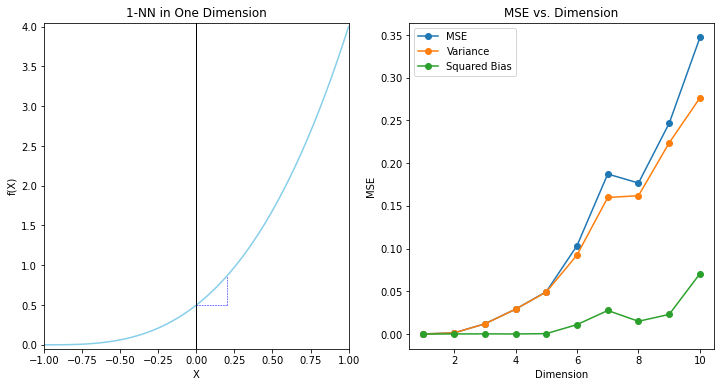

In [19]:
"""FIGURE 2.8. The variance-dominating example."""

#plot the target function (no noise)
import matplotlib.pyplot as plt
import math

def f2(p: int, x: np.ndarray) ->float:
    if p == 1:
        return (x+1)**3/2
    return (x[0]+1)**3/2

x_cords = np.linspace(-1.0, 1.0, 201)
y_cords = [f2(1, x) for x in x_cords]


#The training point (10% of total) is indicated by the blue tick mark.
fig8 = plt.figure(2, figsize=(12, 6))
ax81 = fig8.add_subplot(1, 2, 1)
ax81.plot(x_cords, y_cords, 'skyblue')
ax81.plot([0,0],[-0.05,4.05], color="0", linewidth=1)
ax81.plot([0,0.2],[f2(1,0),f2(1,0)], "b--", linewidth=0.5)
ax81.plot([0.2,0.2],[f2(1, 0), f2(1, 0.2)], "b--", linewidth=0.5)
ax81.set_title('1-NN in One Dimension')
ax81.set_xlabel('X')
ax81.set_ylabel('f(X)')
ax81.margins(0,0)

def generate_data(p: int, n: int) ->np.ndarray:
    if p == 1:
        return np.array([random.uniform(-1, 1) for _ in range(n)])
    return np.array([
        [random.uniform(-1, 1) for _ in range(p)]
        for _ in range(n)
    ])

def simulate(p: int, nsample:int, nsim: int) ->dict:
    res = {'average_distance': 0}
    sum_y = 0
    sum_y_square = 0
    for _ in range(nsim):
        data = generate_data(p, nsample)
        if p == 1:
            data_norm = np.abs(data)
        else:
            data_norm = np.linalg.norm(data, ord=2, axis=1)
        nearest_index = data_norm.argmin()
        nearest_x, nearest_distance = data[nearest_index], data_norm[nearest_index]
        nearest_y = f2(p, nearest_x)
        sum_y += nearest_y
        sum_y_square += nearest_y*nearest_y
        res['average_distance'] += nearest_distance
    average_y = sum_y/nsim
    res['average_distance'] /= nsim
    res['variance'] = sum_y_square/nsim - average_y*average_y
    res['squared_bias'] = (f2(1,0)-average_y)*(f2(1,0)-average_y)
    return res

nsim = 100
data = {p: simulate(p, 1000, nsim) for p in range(1, 11)}
dimension = list(data.keys())
average_distance = [d['average_distance'] for p, d in data.items()]
variance = np.array([d['variance'] for p, d in data.items()])
squared_bias = np.array([d['squared_bias'] for p, d in data.items()])
mse = variance + squared_bias

ax82 = fig8.add_subplot(1, 2, 2)
ax82.set_title('MSE vs. Dimension')
ax82.plot(dimension, mse, 'o-', label='MSE')
ax82.plot(dimension, variance, 'o-', label='Variance')
ax82.plot(dimension, squared_bias, 'o-', label='Squared Bias')
ax82.set_xlabel('Dimension')
ax82.set_ylabel('MSE')
ax82.legend()

plt.show()

### What good about the linear model?

> By imposing some heavy restrictions on the class of models being fitted, we can avoid the curse of dimensionality.

Suppose the relationship between $Y$ and $X$ is linear,

\begin{equation}
Y=X^T\beta+\epsilon,
\end{equation}

where $\epsilon\sim N(0,\sigma^2)$.

We fit the model by least squares to the training data. 

\begin{equation}
\hat{\beta}=(X^TX)^{-1}X^Ty=(X^TX)^{-1}X^T(X\beta+\epsilon)\\
=\beta+(X^TX)^{-1}X^T\epsilon
\end{equation}

For an arbitrary test point $x_0$, we have $\hat{y_0} = x_0^T \hat\beta$,
\begin{equation}
\hat{y}_0=x_0^T\hat{\beta}=x_0^T\beta+x_0^T(X^TX)^{-1}X^T\epsilon\\
=x_0^T\beta+(X(X^TX)^{-1}x_0)^T\epsilon\\
=x_0^T \beta + \sum_{i=1}^N l_i(x_0) \epsilon_i,
\end{equation}


where $l_i(x_0)$ is the $i$th element of $\mathbf{X}\left( \mathbf{X}^T \mathbf{X} \right)^{-1} x_0$.

Since under this model the least squares estimates are unbiased, we find that the expected (squared) prediction error at $x_0$:
Since
\begin{equation}
\text{E}_{y_0|x_0}\text{E}_\mathcal{T}[y_0-x_0^T\beta]=\text{E}_{y_0|x_0}[y_0-x_0^T\beta]\text{E}_\mathcal{T}=0\text{E}_\mathcal{T}=0
\end{equation}

\begin{equation}
\text{E}_{y_0|x_0}\text{E}_\mathcal{T}[y_0-x_0^T\beta]^2=\text{Var}(y_0|x_0)=\sigma^2
\end{equation}
And
\begin{equation}
\text{E}_{y_0|x_0}\text{E}_\mathcal{T}[\text{E}_\mathcal{T}(\hat{y}_0)-\hat{y}_0]=\text{E}_{y_0|x_0}0=0
\end{equation}

And since the expectation of the length $N$ vector $\epsilon$ is zero.

\begin{equation}
\text{E}_\mathcal{T}(\hat{y}_0)-x_0^T\beta=\text{E}_\mathcal{T}(x_0^T\beta+(X(X^TX)^{-1}x_0)^T\epsilon)-x_0^T\beta\\
=\text{E}_\mathcal{T}(X(X^TX)^{-1}x_0)^T\epsilon=0
\end{equation}

And 
\begin{equation}
\text{E}_{y_0|x_0}\Biggl([y_0-x_0^T\beta][\text{E}_\mathcal{T}(\hat{y}_0)-\hat{y}_0]\Biggr)=[\text{E}_\mathcal{T}(\hat{y}_0)-\hat{y}_0]\text{E}_{y_0|x_0}[y_0-x_0^T\beta]=0
\end{equation}


\begin{align}
\text{EPE}(x_0) &= \text{E}_{y_0|x_0}\text{E}_\mathcal{T}\left(y_0-\hat{y}_0\right)^2 \\
&= \text{E}_{y_0|x_0}\text{E}_\mathcal{T}\Biggl([y_0-x_0^T\beta]+[\text{E}_\mathcal{T}(\hat{y}_0)-\hat{y}_0]+[x_0^T\beta-\text{E}_\mathcal{T}(\hat{y}_0)]\Biggr)^2 \\
&= \text{Var}(y_0|x_0) + \text{E}_\mathcal{T} \left(\hat{y}_0 - \text{E}_\mathcal{T}\hat{y}_0\right)^2 + \left(\text{E}_\mathcal{T}\hat{y}_0 - x_0^T\beta\right)^2 \\
&= \text{Var}(y_0|x_0) + \text{Var}_\mathcal{T}(\hat{y}_0) + \text{Bias}^2(\hat{y}_0) \\
&= \text{Var}(y_0|x_0) + \text{Var}_\mathcal{T}(\hat{y}_0) + 0 \\
&= \sigma^2 + \text{E}_\mathcal{T}x_0^T\left(\mathbf{X}^T\mathbf{X}\right)^{-1}x_0\sigma^2.
\end{align}

Note that
1. An additional variance $\sigma^2$ is incurred, since our target is not deterministic.
2. There is no bias, and the variance depends on $x_0$.

If
* $N$ is large,
* $\mathcal{T}$ were selected at random, and
* $\text{E}(X)=0$,

then $\mathbf{X}^T\mathbf{X}\rightarrow N\text{Cov}(X)$ and

\begin{align}
\text{E}_{x_0}\text{EPE}(x_0) &\sim \text{E}_{x_0}x_0^T\text{Cov}(X)^{-1}x_0\sigma^2/N + \sigma^2 \\
&= \text{E}_{x_0}\Bigl[\text{trace}(x_0^T\text{Cov}(X)^{-1}x_0)\Bigr]\sigma^2/N + \sigma^2 \\
&= \text{E}_{x_0}\Bigl[\text{trace}(\text{Cov}(X)^{-1}x_0x_0^T)\Bigr]\sigma^2/N + \sigma^2 \\
&= \Bigl[\text{trace}(\text{Cov}(X)^{-1}\text{Cov}(x_0))\Bigr]\sigma^2/N + \sigma^2 \\
&= \text{trace}\left(\text{Cov}(X)^{-1}\text{Cov}(x_0)\right)\sigma^2/N + \sigma^2 \\
&= \text{trace}(I_p)\sigma^2/N + \sigma^2 \\
&= \sigma^2(p/N)+\sigma^2.
\end{align}

The expected EPE increases linearly as a function of $p$, with slope $\sigma^2/N$. If $N$ is large and/or $\sigma^2$ is small, this growth is variance is negligible (0 in the deterministic case).

By imposing some heavy restrictions on the class of models being fitted, we have avoided the curse of dimensionality. Some of the technical details are derived in Exercise 2.5.

### EPE comparison: 1NN vs. least squares

FIGURE 2.9 compares 1NN vs. least squares in two situations, both of which have the form

\begin{equation}
Y = f(X) + \epsilon,
\end{equation}

* $X$ uniform as before,
* $\epsilon \sim N(0,1)$,
* $N=500$.

For the orange curve, $f(x) = x_1$ is linear in the first coordinate, for the blue curve, $f(x) = \frac{1}{2}(x_1+1)^3$ is cubic as in the figure.

In [23]:
np.random.uniform(-1, 1, size=(10, 3))[:, 0]

array([-0.61759521,  0.59642885,  0.52856294, -0.51102936,  0.7582173 ,
        0.37392417,  0.04149905,  0.38397366,  0.85792946, -0.58157994])

In [47]:
# Cut the dimension using [:, :dim]
np.random.uniform(-1, 1, size=(10, 3))[:, :2]

array([[ 0.01719569,  0.8104598 ],
       [-0.7992207 , -0.1717739 ],
       [ 0.45592493, -0.80862509],
       [ 0.94327868, -0.63571168],
       [-0.61028311,  0.4234042 ],
       [-0.33729951, -0.40925221],
       [ 0.31626791, -0.45314239],
       [-0.02476081, -0.01779324],
       [ 0.75235307, -0.3562242 ],
       [-0.07984536, -0.76341629]])

In [50]:
(np.random.uniform(-1, 1, size=(10, 3))[:, :2])*(np.random.uniform(-1, 1, size=(10, 3))[:, :2])

array([[-0.00848305, -0.14429979],
       [ 0.08565318, -0.71950832],
       [ 0.1717854 , -0.34590402],
       [ 0.03021633, -0.48307884],
       [ 0.77018078,  0.02259718],
       [ 0.10105322, -0.42038542],
       [ 0.18740025, -0.1727471 ],
       [-0.06960062,  0.02860003],
       [-0.35619697, -0.0278165 ],
       [-0.33956579,  0.00973043]])

In [48]:
# use np.hstack to combine the columns
np.hstack((np.ones((10, 1)), np.random.uniform(-1, 1, size=(10, 3))[:, :2]))

array([[ 1.        ,  0.10496641,  0.26744231],
       [ 1.        , -0.21702965,  0.50820341],
       [ 1.        ,  0.42527179,  0.75056226],
       [ 1.        ,  0.61792228,  0.9076206 ],
       [ 1.        , -0.52970636, -0.66967477],
       [ 1.        ,  0.46928742,  0.52278373],
       [ 1.        ,  0.49645549,  0.42786775],
       [ 1.        , -0.97161169,  0.62793184],
       [ 1.        , -0.62037455, -0.75072864],
       [ 1.        ,  0.93673585, -0.89934708]])

In [43]:
# generate random errors with default (mean=0,std=1) distribution
np.random.randn(100).mean()

-0.08955780990662486

In [37]:
np.random.randn(100).std()

1.0511418057538773

In [49]:
np.array([1] + [0]*3)

array([1, 0, 0, 0])

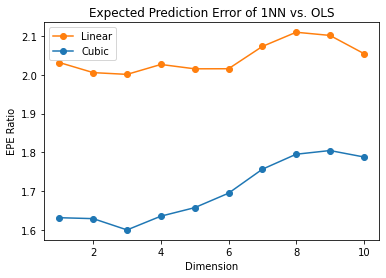

In [20]:
"""FIGURE 2.9. Relative EPE (at x_0 = 0) ratio for 1NN vs. least squares"""
size_simulation = 10000
size_train = 500
p = 10

list_epe_ols_linear = []
list_epe_1nn_linear = []
list_epe_ols_cubic = []
list_epe_1nn_cubic = []

for _ in range(size_simulation):
    epe_linear = []
    # Generate data
    train_x = np.random.uniform(-1, 1, size=(size_train, p))
    # train_y_linear is the first column of train_x (X_1)
    train_y_linear = train_x[:, 0]
    train_y_cubic = ((train_x[:, 0]+1)**3)/2
    train_error = np.random.randn(size_train)
    train_ye_linear = train_y_linear + train_error
    train_ye_cubic = train_y_cubic + train_error
    
    epe_ols_linear = []
    epe_1nn_linear = []
    epe_ols_cubic = []
    epe_1nn_cubic = []
    for dim in range(1, p+1):
        # Cut the dimension
        partial_x = train_x[:, :dim]
        partial_1x = np.hstack((np.ones((size_train, 1)), partial_x))
        
        obs_y_linear = np.random.randn(1)
        obs_y_cubic = .5 + np.random.randn(1)

        # Least squares for linear f
        xx = partial_1x.T @ partial_1x
        xy_linear = partial_1x.T @ train_ye_linear
        xxxy_linear = np.linalg.solve(xx, xy_linear)
        hat_ols = np.array([1] + [0]*dim) @ xxxy_linear
        epe_ols_linear.append((hat_ols-obs_y_linear)**2)

        # 1NN for linear f
        mat_norm = (partial_x*partial_x).sum(axis=1)
        nn = mat_norm.argmin()
        hat_1nn = train_ye_linear[nn]
        epe_1nn_linear.append((hat_1nn-obs_y_linear)**2)
        
        # Least squares for cubic f
        xy_cubic = partial_1x.T @ train_ye_cubic
        xxxy_cubic = np.linalg.solve(xx, xy_cubic)
        hat_ols = np.array([1] + [0]*dim) @ xxxy_cubic
        epe_ols_cubic.append((hat_ols-obs_y_cubic)**2)
        
        # 1NN for cubic f
        hat_1nn = train_ye_cubic[nn]
        epe_1nn_cubic.append((hat_1nn-obs_y_cubic)**2)

    list_epe_ols_linear.append(epe_ols_linear)
    list_epe_1nn_linear.append(epe_1nn_linear)
    list_epe_ols_cubic.append(epe_ols_cubic)
    list_epe_1nn_cubic.append(epe_1nn_cubic)

arr_epe_ols_linear = np.array(list_epe_ols_linear)
arr_epe_1nn_linear = np.array(list_epe_1nn_linear)
arr_epe_ols_cubic = np.array(list_epe_ols_cubic)
arr_epe_1nn_cubic = np.array(list_epe_1nn_cubic)

# Compute EPE, finally
epe_ols_linear = arr_epe_ols_linear.mean(axis=0)
epe_1nn_linear = arr_epe_1nn_linear.mean(axis=0)
epe_ols_cubic = arr_epe_ols_cubic.mean(axis=0)
epe_1nn_cubic = arr_epe_1nn_cubic.mean(axis=0)

# Plot
plot_x = list(range(1, p+1))
fig4 = plt.figure(4)
ax41 = fig4.add_subplot(1, 1, 1)
ax41.plot(plot_x, epe_1nn_linear/epe_ols_linear, '-o',
          color='C1', label='Linear')
ax41.plot(plot_x, epe_1nn_cubic/epe_ols_cubic, '-o',
          color='C0', label='Cubic')
ax41.legend()
ax41.set_xlabel('Dimension')
ax41.set_ylabel('EPE Ratio')
ax41.set_title('Expected Prediction Error of 1NN vs. OLS')
plt.show()

In [54]:
# list_epe_ols_linear is 10000 X 10 list
len(list_epe_ols_linear)

10000

In [52]:
# arr_epe_ols_linear is 10000 X 10 array
len(arr_epe_ols_linear)

10000

In [55]:
epe_ols_linear

array([[0.98240917],
       [0.97851524],
       [1.01285594],
       [1.00377149],
       [0.99835949],
       [1.00265193],
       [1.00174265],
       [0.99765609],
       [1.02053042],
       [1.00488109]])

#### Linear case

Shown is the relative EPE of 1NN to least squares, which appears to start at around 2 for the linear case.

Least squares is unbiased in this case, and as discussed above the EPE is slightly above $\sigma^2 = 1$.

The EPE for 1NN is always above 2, since the variance of $\hat{f}(x_0)$ in this case is at least $\sigma^2$, and the ratio increases with dimension as the nearest neighbor strays from the target point.

#### Cubic case

For the cubic case, least squares is biased, which moderates the ratio.

Clearly we could manufacture examples where the bias of least squares would dominate the variance, and the 1NN would come out the winner.

> By relying on rigid assumptions, the linear model has no bias at all and negligible variance, while the error in 1-nearest neighbor is substantially larger. However, if the assumptions are wrong, all bets are off and the 1-nearest neighbor may dominate. We will see that there is a whole spectrum of models between the rigid linear models and the extremely flexible 1-nearest-neighbor models, each with their own assumptions and biases, which have been proposed specifically to avoid the exponential growth in complexity of functions in high dimensions by drawing heavily on these assumptions.

Before we delve more deeply, let us elaborate a bit on the concept of _statistical models_ and see how they fit into the prediction framework.

# $\S$ 2.6. Statistical Models, Supervised Learning and Function Approximation

### Review

Our goal is to find a useful approximation $\hat{f}(x)$ to $f(x)$ that underlies the predictive relationship between the inputs and outputs.

In the theoretical setting of $\S$ 2.4, we saw that
1. for a quantitative response, squared error loss lead us to the regression function  

  \begin{equation}
  f(x) = \text{E}(Y|X=x).
  \end{equation}

2. The kNNs can be viewed as direct estimates of this conditional expectation,
3. but kNNs can fail at least two ways:
  * If the dimension of the input space is high, the nearest neighbors need not be close to the target point, and can result in large errors,
  * if special structure is known to exist, this can be used to reduce both the bias and the variance of the estimates.
  
> We anticipate using other classes of models for $f(x)$, in many cases specifically designed to overcome the dimensionality problems, and here we discuss a framework for incorporating them into the prediction problem.

## $\S$ 2.6.1. A Statistical Model for the Joint Distribution $\text{Pr}(X,Y)$

### The additive error model
Suppose in fact that our data arose from a statistical model

\begin{equation}
Y = f(X) + \epsilon,
\end{equation}

where the random error $\epsilon$ has $\text{E}(\epsilon)=0$ and is independent of $X$.

Note that for this model,

\begin{equation}
f(x)=\text{E}(Y|X=x),
\end{equation}

and in fact the conditional distribution $\text{Pr}(Y|X)$ depends on $X$ only through the conditional mean $f(x)$.

The additive error model is a useful approximation to the truth. For most systems the input-output pairs $(X,Y)$ will not have a deterministic relationship $Y=f(X)$. Generally there will be other unmeasured variables that also contribute to $Y$, including measurement error.

The additive model assumes that we can capture all these departures from a deterministic relationship via the error $\epsilon$.

#### Where the deterministic rules

For some problems a deterministic relationship does hold. Many of the classification problems studied in machine learning are of this form, where the response surface can be thought of as a colored map defined in $\mathbb{R}^p$.

The training data consist of colored examples from the map $\{x_i,g_i\}$, and the goal is to be able to color any point. Here the function is deterministic, and the randomness enters through the $x$ location of the training points.

For the moment we will not pursue such problems, but will see that they can be handled by techniques appropriate for the error-based models.

### The i.i.d. assumption

The assumption in the above additive error model that the errors are i.i.d. is not strictly necessary, but seems to be the back of our mind when we average squared errors uniformly in our EPE criterion.

With such a model it becomes natural to use least squares as a data criterion for model estimation as in the linear model

\begin{equation}
\hat{Y} = \hat\beta_0 + \sum_{j=1}^p X_j \hat\beta_j.
\end{equation}

Simple modifications can be made to avoid the independence assumption; e.g., we can have

\begin{equation}
\text{Var}(Y|X=x)=\sigma(x),
\end{equation}

and now both the mean and variance depend on $X$.

In general $\text{Pr}(Y|X)$ can depend on X in complicated ways, but the additive error model precludes these.

### For qualitative outputs

So far we have concentrated on the quantitative response.

Additive error models are typically not used for qualitative outputs $G$; in this case the target function $p(X)$ _is_ the conditional density $\text{Pr}(G|X)$, and this is modeled directly.

For example, for two-class data, it is often reasonable to assume that the data arise from independent binary trials, with the probability of one particular outcome being $p(X)$, and the other $1 − p(X)$. Thus if $Y$ is the 0–1 coded version of $G$, then
\begin{equation}
\text{E}(Y |X = x) = p(x),
\end{equation}

but the variance depends on $x$ as well: $\text{Var}(Y |X = x) = p(x)\left(1 − p(x)\right)$.

## $\S$ 2.6.2. Supervised Learning

Before we launch into more statistically oriented jargon, we present the function-fitting paradigm from a machine learning point of view.

Suppose for simplicity the additive error model

\begin{equation}
Y = f(X) + \epsilon
\end{equation}

is a reasonable assumption.

Supervised learning attempts to learn $f$ by example through a _teacher_. One observes the system under study, both the inputs and outputs, and assembles a _training_ set of observations

\begin{equation}
\mathcal{T} = \left\{ (x_i, y_i) : i = 1, \cdots, N \right\}.
\end{equation}

The observed input values to the system $x_i$ are also fed into an artificial system, known as a learning algorithm (usually a computer program), which also produces outputs $\hat{f}(x_i)$ in response to the inputs.

The learning algorithm has the property that it can modify its input/output relationship $\hat{f}$ in response to differences $y_i − \hat{f}(x_i)$ between the original and generated outputs. This process is known as _learning by example_. Upon completion of the learning process the hope is that the artificial and real outputs will be close enough to be useful for all sets of inputs likely to be encountered in practice.

This learning paradigm has been the motivation for research into the supervised learning problem in the fields of machine learning (with analogies to human reasoning) and neural networks (with biological analogies to the brain). The approach taken in applied mathematics and statistics has been from the perspective of function approximation and estimation.

## $\S$ 2.6.3. Function Approximation

Here
* the data pairs $\{x_i, y_i\}$ are viewed as points in a $(p+1)$-dimensional Euclidean space.
* The function $f(x)$ has domain eqaul to the $p$-dimensional input subspace (or $\mathbb{R}^p$ for convenience), and
* $f$ is related to the data via a model such as $y_i=f(x_i)+\epsilon$.

The goal is to obtain a useful approximation to $f(x)$ for all $x$ in some region of $\mathbb{R}^p$, given the representations in $\mathcal{T}$.

> Although somewhat less glamorous than the learning paradigm, treating supervised learning as a problem in function approximation encourages the geometrical concepts of Euclidean spaces and mathematical concepts of probabilsitic inference to be applied to the problem. This is the approach taken in this book.

### Associated parameters and basis expansions

Many of the approximations we will encounter have associated a set of parameters $\theta$ that can be modified to suit the data at hand. For example, the linear model

\begin{equation}
f(x) = x^T\beta
\end{equation}

has $\theta=\beta$.

Another class of useful approximators can be expressed as _linear basis expansions_
\begin{equation}
f_\theta(x) = \sum_{k=1}^K h_k(x)\theta_k,
\end{equation}
where the $h_k$ are a suitable set of functions or transformations of the input vector $x$. Traditional examples are polynomial and trigonometric expansions, where for example $h_k$ might be $x_1^2$, $x_1x_2^2$, $\text{cos}(x_1)$ and so on.

We also encounter nonlinear expansions, such as the sigmoid transformation common to neural network models,
\begin{equation}
h_k(x) = \frac{1}{1+\text{exp}(-x^T\beta_k)}.
\end{equation}

### Least squares again
We can use least squares to estimate the parameters $\theta$ in $f_\theta$ as we did for the linear model, by minimizing the residual sum-of-squares
\begin{equation}
\text{RSS}(\theta) = \sum_{i=1}^N\left(y_i-f_\theta(x_i)\right)^2
\end{equation}
as a function of $\theta$. This seems a reasonable criterion for an additive error model.

In terms of function approximation, we imagine our parametrized function as a surface in $p+1$ space, and what we observe are noisy realizations from it. This is easy to visualize when $p=2$ and the vertical coordinate in the output $y$, as in FIGURE 2.10. The noise is in the output coordinate, so we find the set of parameters such that the fitted surface gets as close to the observed points as possible, where close is measured by the sum of squared vertical errors in $\text{RSS}(\theta)$.

For the linear model we get a simple closed form solution to the minimization problem. This is also true for the basis function methods, if the basis functions themselves do not have any hidden parameters. Otherwise the solution requires either iterative methods or numerical optimization.

While least squares is generally very convenient, it is not the only criterion used and in some cases would not make much sense. A more general principle for estimation is _maximum likelihood estimation_.

### Maximum likelihood estimation

Suppose we have a random sample $y_i, i=1,\cdots,N$ from a density $\text{Pr}_\theta(y)$ indexed by some parameters $\theta$. The log-probability of the observed sample is

\begin{equation}
L(\theta) = \sum_{i=1}^N\log\text{Pr}_\theta(y_i).
\end{equation}

> The principle of maximum likelihood assumes that the most reasonable values for $\theta$ are those for which the probability of the observed sample is largest.

#### Least squares = ML with Gaussian errors
Least squares for the additive error model $Y = f_\theta(X) + \epsilon$, with $\epsilon \sim N(0, \sigma^2)$, is equivalent to maximum likelihood using the conditional likelihood

\begin{equation}
\text{Pr}(Y|X,\theta) = N(f_\theta(X), \sigma^2).
\end{equation}

So although the additional assumption of normality seems more restrictive, the results are the same. The log-likelihood of the data is

\begin{equation}
L(\theta) = -\frac{N}{2}\log(2\pi) - N\log\sigma - \frac{1}{2\sigma^2} \sum_{i=1}^N \left( y_i - f_\theta(x_i) \right)^2,
\end{equation}

and the only term involving $\theta$ is the last, which is $\text{RSS}(\theta)$ up to a scalar negative multiplier.

#### Multinomial likelihood for a qualitative output $G$

A more interesting example is the multinomial likelihood for the regression function $\text{Pr}(G|X)$ for a qualitative output $G$.

Suppose we have a model

\begin{equation}
\text{Pr}(G=\mathcal{G}_k|X=x) = p_{k,\theta}(x), k=1,\cdots,K
\end{equation}

for the conditional density of each class given $X$, indexed by the parameter vector $\theta$. Then the log-likelihood (also referred to as the cross-entropy) is

\begin{equation}
L(\theta) = \sum_{i=1}^N\log p_{g_i,\theta}(x_i),
\end{equation}

and when maximized it delivers values of $\theta$ that best conform with the data in the likelihood sense.

# $\S$ 2.7. Structured Regression Models

### Review & motivation

We have seen that although nearest-neighbor and other local methods focus directly on estimating the function at a point, they face problems in high dimensions. They may also be inappropriate even in low dimensions in cases where more structured approaches can make more efficient use of the data.

This section introduces classes of such structured approaches. Before we proceed, though, we discuss further the need for such classes.

## $\S$ 2.7.1. Difficulty of the Problem

Consider the RSS criterion for an arbitrary function $f$,

\begin{equation}
\text{RSS}(f) = \sum_{i=1}^N \left( y_i - f(x_i) \right)^2.
\end{equation}

Minimizing the RSS leads to infinitely many solutions: Any function $\hat{f}$ passing through the training points $(x_i,y_i)$ is a solution. Any particular solution chosen might be a poor predictor at test points different from the training points.

If there are multiple observation pairs $(x_i,y_{il})$, $l=1,\cdots,N_i$, at each value of $x_i$, the risk is limited. In this case, the solution pass through the average values of the $y_{il}$ at each $x_i$ (Exercise 2.6). The situation is similar to the one we have already visited in $\S$ 2.4; indeed, the above RSS is the finite sample version of the expected prediction error

\begin{equation}
\text{EPE}(f) = \text{E}\left( Y - f(X) \right)^2 = \int \left( y - f(x) \right)^2 \text{Pr}(dx, dy).
\end{equation}

### Necessity & limit of the restriction

If the sample size $N$ were sufficiently large such that repeats were guaranteed and densely arranged, it would seem that these solutions might all tend to the limiting conditional expectation.

In order to obtain useful results for finite $N$, we must restrict the eligible solution to the RSS to a smaller set of functions.

> How to decide on the nature of the restrictions is based on considerations outside of the data.

These restrictions are somtimes
* encoded via the parametric representation of $f_\theta$, or
* may be built into the learning method itself, either implicitly or explicitly.

> These restricted classes of solutions are the major topic of this book.

One thing should be clear, though.

> Any restrictions imposed on $f$ that lead to a unique solution to RSS do not really remove the ambiguity caused by the multiplicity of solutions. There are infinitely many possible restrictions, each leading to a unique solution, so the abmiguity has simply been transferred to the choice of constraint.

### Complexity

In general the constraints imposed by most learning methods can be described as _complexity_ restrictions of one kind or another.

> This usually means some kind of regular behavior in small neighborhoods of the input space.

That is, for all input points $x$ sufficiently close to each other in some metric, $\hat{f}$ exhibits some special structure such as
* nearly constant,
* linear or
* low-order polynomial behavior.

The estimator is then obtained by averaging or polynomial fitting in that neighborhood.

The strength of the constraint is dictated by the neighborhood size.

> The larger the size, the stronger the constraint, and the more sensitive the solution is to the particular choice of constraint.

For example,
* local constant fits in infinitesimally small neighborhoods is no constraints at all;
* local linear fits in very large neighborhoods is almost a globally llinear model, and is very restrictive.

### Metric

The nature of the constraint depends on the metric used.

Some methods, such as kernel and local regression and tree-based methods, directly specify the metric and size of the neighborhood. The kNN methods discussed so far are based on the assumption that locally the function is constant; close to a target input $x_0$, the function does not change much, and so close outputs can be averagedd to produce $\hat{f}(x_0)$.

Other methods such as splines, neural networks and basis-function methods implicitly define neighborhoods of local behavior. In $\S$ 5.4.1 we discuss the concept of an _equivalent kernel_, which describes this local dependence for any method linear in the outputs. These equivalent kernels in many cases look just like the explicitly defined weighting kernels discussed above -- peaked at the target point and falling smoothly away from it.

### Curse of dimensionality

One fact should be clear by now. Any method that attempts to produce locally varying functions in small isotopic neighborhoods will run into problems in high dimensions -- again the curse of dimensionality.

And conversely, all methods that overcome the dimensionality problems have an associated -- and often implicit or adaptive -- metric for measuring neighborhoods, which basically does not allow the neighborhood to be simultaneously small in all directions.

# $\S$ 2.8. Classes of Restricted Estimators

The variety of nonparametric regression techniques or learning methods fall into a number of different classes depending on the nature of the restrictions imposed. These classes are not distinct, and indeed some methods fall in several classes.

Each of the classes has associated with it one or more parameters, sometimes appropriately called _smoonthing_ parameters, that control the effective size of the local neighborhood.

Here we describe three broad classes.

## $\S$ 2.8.1. Roughness Penalty and Bayesian Methods

Here the class of functions is controlled by explicitly penalizing $\text{RSS}(f)$ with a roughness penalty $J$

\begin{equation}
\text{PRSS}(f;\lambda) = \text{RSS}(f) + \lambda J(f),
\end{equation}

where the user-selected functional $J(f)$ will be large for functions $f$ that vary too rapidly over small regions of input space.

#### Cubic smoothing spline

For example, the popular *cubic smoothing spline* for one-dimensional inputs is the solution to the penalized least-squares criterion

\begin{equation}
\text{PRSS}(f;\lambda) = \sum_{i=1}^N \left(y_i-f(x_i)\right)^2 + \lambda\int\left[f''(x)\right]^2 dx.
\end{equation}

This roughness penalty controls large values of the second derivative of $f$, and the amount penalty is dictated by $\lambda \ge 0$. For $\lambda =0$ no penalty is imposed, and any interpolating will do, while for $\lambda = \infty$ only functions linear in $x$ are permitted.

### Various penalties

Penalty functionals $J$ can be constructed for functions in any dimension, and special versions can be created to impose special structure. For example, additive penalties

\begin{equation}
J(f) = \sum_{j=1}^p J(f_j)
\end{equation}

are used in conjunction with additive functions $f(X) = \sum_{j=1}^p f_j(X_j)$ to create additive models with smooth coordinate functions.

Similarly, _projection pursuit regression_ models have

\begin{equation}
f(X) = \sum_{m=1}^M g_m(\alpha_m^T X)
\end{equation}

for adaptively chosen direction $\alpha_m$, and the functions $g_m$ can each have an associated roughness penalty.

### Connection with Bayesian framework

Penalty function, or _regularization_ methods, express our prior belief that the type of functions we seek exhibits a certain type of smooth behavior, and indeed can usually be cast in a Bayesian framework.
* The penalty $J$ corresponds to a log-prior, and
* $\text{PRSS}(f;\lambda)$ the log-posterior distribution, and
* minimizing $\text{PRSS}$ amounts to finding the posterior mode.

We discuss roughness-penalty approaches in Chapter 5 and the Bayesian paradigm in Chapter 8.

## $\S$ 2.8.2. Kernel Methods and Local Regression

These methods can be thought of as explicitly providing estimates of the regression function or conditional expectation by specifying the nature of the local neighborhood, and of the class of regular functions fitted locally.

The local neighborhood is specified by a _kernel function_ $K_\lambda(x_0, x)$ which assigns weights to points $x$ in a region around $x_0$ (FIGURE 6.1). For example, the Gaussian kernel has a weight function based on the Gaussian density function

\begin{equation}
K_\lambda(x_0, x) = \frac{1}{\lambda}\exp\left(-\frac{\|x-x_0\|^2}{2\lambda}\right),
\end{equation}

and assigns weights to points that die exponentially with their squared Euclidean distance from $x_0$. The parameter $\lambda$ corresponds to the variance of the Gaussian density, and controls the width of the neighborhood.

The simplest form of kernel estimate is the Nadaraya-Watson weighted average

\begin{equation}
\hat{f}(x_0) = \frac{\sum_{i=1}^N K_\lambda(x_0, x_i)y_i}{\sum_{i=1}^N K_\lambda(x_0, x_i)}.
\end{equation}

### Formulation

In general, we can define a local regression estimate of $f(x_0)$ as $f_{\hat{\theta}}(x_0)$, where $\hat{\theta}$ minimizes

\begin{equation}
\text{RSS}(f_\theta,x_0) = \sum_{i=1}^N K_\lambda(x_0, x_i)\left(y_i -f_\theta(x_i)\right)^2,
\end{equation}

where $f_\theta$ is some parameterized function, such as a low-order polynomial. Some examples are:
* $f_\theta(x) = \theta_0$, the constant function; this results in the Nadaraya-Watson estimate.
* $f_\theta(x) = \theta_0+\theta_1 x$ gives the popular local linear regression model.

### Association between kernel methods and kNN

Nearest-neighbor methods can be thought of as kernel methods having a more data-dependent metric. Indeed, the metric for kNN is

\begin{equation}
K_k(x,x_0) = I\left(\|x-x_0\| \le \|x_{(k)}-x_0\|\right),
\end{equation}

where
* $x_{(k)}$ is the training observation ranked $k$th in distance from $x_0$, and
* $I(S)$ is the indicator of the set $S$.

These methods of course need to be modified in high dimensions, to avoid the curse of dimensionality.

Various adaptations are discussed in Chapter 6.

## $\S$ 2.8.3. Basis functions and Dictionary Methods

This class of methods includes the familiar linear and polynomial expansions, but more importantly a wide variety of more flexible models.

### Linear expansion

The model for $f$ is a linear expansion of basis functions

\begin{equation}
f_\theta(x) = \sum_{m=1}^M\theta_m h_m(x),
\end{equation}

where each of the $h_m$ is a function of the input $x$, and the term linear here refers to the action of the parameter $\theta$.

This class covers a wide variety of methods.

In some cases the sequence of basis functions is prescribed, such as a basis for polynomials in $x$ of total degree $M$.

#### Splines

For 1D $x$, polynomial splines of degree $K$ can be represented by an appropriate sequence of $M$ spline basis functions, determined in turn by $M-K-1$ _knots_. These produce functions that are piecewise polynomials of degree $K$ between the knots, and joined up with continuity of degree $K-1$ at the knots.

#### Linear splines

As an example consider linear splines, or piecewise linear functions. One intuitively satisfying basis consist of the functions

\begin{align}
b_1(x) &= 1, \\
b_2(x) &= x, \\
b_{m+2}(x) &= (x - t_m)_+, m=1,\cdots,M-2,
\end{align}

where
* $t_m$ is the $m$th knot, and
* $z_+$ denotes positive part.

Tensor products of spline bases can be used for inputs with dimensions larger than one ($\S$ 5.2, and the CART/MARS model in Chapter 9).

The parameter $M$ controls the degree of the polynomial or the number of knots in the case of splines.

### Radial basis functions

_Radial basis functions_ are symmetric $p$-dimensional kernels located at particular centroids,

\begin{equation}
f_\theta(x) = \sum_{m=1}^M K_{\lambda_m}(\mu_m,x) \theta_m,
\end{equation}

e.g., the Gaussian kernel $K_\lambda(\mu,x)=e^{-\|x-\mu\|^2/2\lambda}$ is popular.

Radial basis functions have centroids $\mu_m$ and scales $\lambda_m$ that have to be determined. The spline basis functions have knots. In general we would like the data to dictate them as well.

> Including these as parameters changes the regression problem from a straightforward linear problem to a combinatorially hard nonlinear problem.

In practice, shortcuts such as greedy algorithms or two stage processes are used ($\S$ 6.7).

### Neural networks

A single-layer feed-forward neural network model with linear output weights can be thought of as an adaptive basis function method.

The model has the form

\begin{equation}
f_\theta(x) = \sum_{m=1}^M \beta_m \sigma(\alpha_m^T x + b_m),
\end{equation}

where

\begin{equation}
\sigma(x) = \frac{1}{1+e^{-x}}
\end{equation}

is known as the _activation_ function.

Here, as in the projection pursuit model, the directions $\alpha_m$ and the _bias_ term $b_m$ have to be determined, and their estimation is the meat of the computation (Chapter 11).

### Dictionary

These adaptively chosen basis function methods are a.k.a. _dictionary_ methods, where one has available a possibly infinite set or dictionary $\mathcal{D}$ of candidate basis functions from which to choose, and models are built up by employing some kind of search mechanism.

# $\S$ 2.9. Model Selection and the Bias-Variance Tradeoff

### Review

All the Models described so far have a *smoothing* or *complexity* parameter that has to be determined:
* The multiplier of the penalty term;
* the width of the kernel;
* or the number of basis functions.

In the case of the smoothing spline, the parameter $\lambda$ indexes models ranging from a straight line fit to the interpolating model.

Similarly a local degree-$m$ polynomial model ranges between a degree-$m$ global polynomial when the window size is infinitely large, to an interpolating fit when the window size shrinks to zero.

This means that we cannot use residual sum-of-squares on the training data to determine these parameters as well, since we would always pick those that gave interpolating fits and hence zero residuals. Such a model is unlikely to predict future data well at all.

### The bias-variance tradeoff for the kNN

The kNN regression fit $\hat{f}_k(x_0)$ usefully illustrates the competing forces that affect the predictive ability of such approximations.

Suppose
* the data arise from a model $Y=f(X)+\epsilon$, with $\text{E}(\epsilon)=0$ and $\text{Var}(\epsilon)=\sigma^2$;
* for simplicity here the values of $x_i$ in the sample are fixed in advance (nonrandom).

The expected prediction error at $x_0$, a.k.a. _test_ or _generalization_ error, can be decomposed:

\begin{align}
\text{EPE}_k(x_0) &= \text{E}\left[(Y-\hat{f}_k(x_0))^2|X=x_0\right] \\
&= \text{E}\left[(Y -f(x_0) + f(x_0) -\hat{f}_k(x_0))^2|X=x_0\right] \\
&= \text{E}(\epsilon^2) + 2\text{E}\left[\epsilon(f(x_0) -\hat{f}_k(x_0))|X=x_0\right] + \text{E}\left[\left(f(x_0)-\hat{f}_k(x_0)\right)^2|X=x_0\right] \\
&= \sigma^2 + 0+ \left[\text{Bias}^2(\hat{f}_k(x_0))+\text{Var}_\mathcal{T}(\hat{f}_k(x_0))\right] \\
&= \sigma^2 + \left(f(x_0) - \frac{1}{k}\sum_{l=1}^k f(x_{(l)})\right)^2 + \frac{\sigma^2}{k}
\end{align},

where subscripts in parentheses $(l)$ indicate the sequence of nearest neighbors to $x_0$.

There are three terms in this expression.

#### Irreducible error
The first term $\sigma^2$ is the *irreducible* error -- the variance of the new test target -- and is beyond our control, even if we know the true $f(x_0)$.

The second and third terms are under our control, and make up the _mean squared error_ of $\hat{f}_k(x_0)$ in estimateing $f(x_0)$, which is broken down into a bias component and a variance component.

#### Bias
The bias term is the squared difference between the true mean $f(x_0)$ and the expected value of the estimate, i.e.,

\begin{equation}
\left[ \text{E}_\mathcal{T} \left( \hat{f}_k(x_0) \right) - f(x_0) \right]^2,
\end{equation}

where the expectation averages the randomness in the training data.

This term will most likely increase with $k$, if the true function is reasonably smooth. For small $k$ the few closest neighbors will have values $f(x_{(l)})$ close to $f(x_0)$, so their average should be close to $f(x_0)$. As $k$ grows, the neighbors are further away, and then anything can happen.

#### Variance
The variance term is simply the variance of an average here, and decreases as the inverse of $k$.

#### Finally, the tradeoff
So as $k$ varies, there is a *bias-variance tradeoff*.

More generally, as the _model complexity_ of our procedure is increased, the variance tends to increase and the squared bias tends to decrease, vice versa. For kNN, the model complexity is controlled by $k$.

Typically we would like to choose our model complexity to trade bias off with variance in such a way as to minimize the test error. An obvious estimate of test error is _training error_

\begin{equation}
\frac{1}{N} \sum_i (y_i \hat{y}_i)^2.
\end{equation}

Unfortunately training error is not a good estimate of test error, as it does not properly account for model complexity.

### Interpretation & implication
FIGURE 2.11 shows the typical behavior of the test and training error, as model complexity is varied.

> The training error tends to decrease whenever we increase the model complexity, i.e., whenever we fit the data harder.

However with too much fitting, the model adapts itself too closely to the training data, and will not generalize well (i.e., have large test error). In that case the predictions $\hat{f}(x_0)$ will have large variance, as reflected in the above EPE expression.

In contrast, if the model is not complex enough, it will _underfit_ and may have large mias, again resulting in poor generalization. In Chapter 7 we discuss methods for estimating the test error of a prediction method, and hence estimating the optimal amount of model complexity fir a given prediction method and training set.

# $\S$ Exercises
## Ex. 2.1 (target coding)

Suppose each of $K$-classes has an associated target $t_k$, which is a vector of all zeros, except a one in the $k$th position. Show that classifying to
the largest element of $\hat{y}$ amounts to choosing the closest target, $\text{min}_k||t_k − \hat{y}||$, if the elements of $\hat{y}$ sum to one.

We have some input data $x$. Some algorithm assigns to $x$ the probability $y_k$ that $x$ is a member of the $k$-th class. This would explain why the sum of the $y_k$ is equal to one.
For each $k$ with $1 \leq k \leq K$, let $t_k$ be the $K$-dimensional vector that has $1$ in the $k$-th position and $0$ elsewhere. 
\begin{align}
\text{argmin}_k||y-t_k||&=\text{argmin}_k||y-t_k||^2\\
&=\text{argmin}_k\sum_{i=1}^{K}(y_i-(t_k)_i)^2\\
&=\text{argmin}_k\sum_{i=1}^{K}\Bigl(y_i^2-2y_i(t_k)_i+(t_k)_i^2\bigr)\\
&=\text{argmin}_k\sum_{i=1}^{K}\Bigl(-2y_i(t_k)_i+(t_k)_i^2\bigr)\\
\end{align}
Since $\sum_{i=1}^{K}y_i^2$ is the same for all classes $k$. For each $k$, the sum $\sum_{i=1}^{K}(t_k)_i^2=1$. Also $\sum_{i=1}^{K}y_i(t_k)_i=y_k$. This means that  
\begin{align}
\text{argmin}_k||y-t_k||&=\text{argmin}_k(-2y_k+1)\\
&=\text{argmin}_k(-2y_k)\\
&=\text{argmax}_k(y_k)\\
\end{align}
Then, for any $K$-dimensional vector $y$, the $k$ for which $y_k$ is largest coincides with the $k$ for which $t_k$ is nearest to $y$.

## Ex. 2.2 (the oracle revealed)

Show how to compute the Bayes decision boundary for the simulation example 
in Figure 2.5.

The simulation draws $10$ “blue” centering points $p_1, \cdots, p_{10} \in \mathbb{R}^2$ from $N\Biggl(\begin{bmatrix}
1\\
0\\
\end{bmatrix}, I_2\Biggr)$ and $10$ “orange” centering points $q_1, \cdots, q_{10} \in \mathbb{R}^2$ from $N\Biggl(\begin{bmatrix}
0\\
1\\
\end{bmatrix}, I_2\Biggr)$.  The multivariate Gaussian densities:

$$f_X(\mathbf x)=\frac{1}{(2\pi)^{p/2}|\mathbf\Sigma|^{1/2}}e^{-\frac{1}{2}(\mathbf x-\boldsymbol \mu)^T(\mathbf\Sigma)^{-1}(\mathbf x-\boldsymbol \mu)}$$

The $p\times p$ matrix $\mathbf \Sigma$ is the variance–covariance matrix of $\mathbf X$.  

The covariance matrix $$\mathbf \Sigma=\begin{bmatrix}
\sigma_{11}&\sigma_{12}\\
\sigma_{12}&\sigma_{22}
\end{bmatrix}
$$  $$\mathbf \Sigma^{-1}=\frac{1}{\sigma_{11}\sigma_{22}-\sigma_{12}^2}\begin{bmatrix}
\sigma_{22}&-\sigma_{12}\\
-\sigma_{12}&\sigma_{11}
\end{bmatrix}
$$

The formula for the Bayes decision boundary is given by equating posterior probabilities. We get an equation in the unknown $z \in \mathbb R^2$, giving a curve in the plane:  
\begin{equation}
P(\text{blue})\exp(-\sum_{i=1}^{10}\lVert p_i-z\lVert ^2/2)=P(\text{orange)})\exp(-\sum_{j=1}^{10}\lVert q_j-z\lVert ^2/2)
\end{equation}  

In this solution, the boundary is given as the equation of equality between the two probabilities, with the $p_i$ and $q_j$ constant and fixed by previously performed sampling. Each time one re-samples the $p_i$ and $q_j$ , one obtains a different Bayes decision boundary. Note that if the prior probabilities are equal (as they seem to be in this example) we have 
$$P(\text{blue})=P(\text{orange)})=\frac{1}{2}$$
and they also cancel.

## Ex. 2.3 (the median distance to the origin)
Consider $N$ data points uniformly distributed in a $p$-dimensional unit ball centered at the origin. Suppose we consider a nearest-neighbor estimate at the origin. The median distance from the origin to the closest data point is given by the expression  
$$d(p,N)=\Bigl(1-\frac{1}{2}^{1/N}\Bigr)^{1/p}$$

We derive the distribution function (CDF) for the Euclidean distance (denoted by $y$) from the origin to the closest point of $n$ points $x_i$ where each point $x_i$ is drawn uniformly from a $p$-dimensional unit ball centered at the origin. The distribution function of $y=\lVert x_i\rVert$ is the ratio of the volume of a ball of radius $y$ and the volume of a ball of radius one. This ratio is $y^p$ and so $F(y)=y^p$. The distribution function for $y$ is then $f(y)=F'(y)=py^{p-1}$. 

Given $N$ such vectors $\{x_i\}_{i=1}^N$ the distribution function for the smallest radius $Y_1$ (from all of them) is given by $$F_{Y_1}(y)=1-(1-F(y))^N=1-(1-y^p)^N$$
The median distance for $Y_1$ is found by solving for $y$ in $$\frac{1}{2}=F_{Y_1}(y)$$ This gives $$y=\Bigl(1-\frac{1}{2}^{1/N}\Bigr)^{1/p}=d_{median}(p,N)$$.

The density function for $Y_1$ is given by the derivative of the distribution function $F_{Y_1}(y)$:

$$f_{Y_1}(y)=N(1-y^p)^{N-1}(py^{p-1})=pN(1-y^p)^{N-1}y^{p-1}$$

Then the mean distance to the closest of these $N$ points is given by

$$d_{\text{mean}}(p,N)\equiv \int_{0}^{1}yf_{Y_1}(y)dy=pN\int_{0}^{1}(1-y^p)^{N-1}y^pdy\\
=N\int_{0}^{1}(1-t)^{N-1}ydt\quad(t=y^p)\\
=N\int_{0}^{1}(1-t)^{N-1}t^{1/p}dt\\
=NB(N,\frac{1}{p}+1)$$ 

The Beta function is:

$$B(x,y)=\int_{t=0}^{t=1}t^{(x-1)}(1-t)^{(y-1)}dt,\quad (x>0 ;\quad y>0)$$



## Ex. 2.4 (projections a^T x are distributed as normal N(0, 1)) 

The edge effect problem discussed on page 23 is not peculiar to
uniform sampling from bounded domains. Consider inputs drawn from a
spherical multinormal distribution $X \sim N(0, I_p)$. The squared distance
from any sample point to the origin has a $\chi^2_p$ distribution with mean $p$. Consider a prediction point $x_0$ drawn from this distribution, and let $$a = x_0/\lVert x_0\rVert$$ be an associated unit vector. Let $z_i = a^Tx_i$ be the projection of each of the training points on this direction. 


Show that the $z_i$ are distributed $N(0, 1)$ with expected squared distance
from the origin $1$, while the target point has expected squared distance $p$
from the origin.

Hence for $p = 10$, a randomly drawn test point is about $3.1$ standard deviations from the origin, while all the training points are on average
one standard deviation along direction $a$. So most prediction points see
themselves as lying on the edge of the training set.

The main point is that $\sum\lVert x_i\rVert^2$ is invariant under the orthogonal group. As a consequence the standard normal distribution exists on any finite dimensional inner product space (by fixing an orthonormal basis). Further, if $\mathbb R^p$ is written as the orthogonal sum of two vector
subspaces, then the product of standard normal distributions on each of the subspaces gives the standard normal distribution on $\mathbb R^p$.

## Ex. 2.5 (the expected prediction error under least squares)
(a) Derive equation (2.27). The last line makes use of (3.8) through a
conditioning argument.

(b) Derive equation (2.28), making use of the cyclic property of the trace
operator $[\text{trace}(AB) = \text{trace}(BA)]$, and its linearity (which allows us to interchange the order of trace and expectation).

(a): 
equation (2.27)
\begin{align}
\text{EPE}(x_0) &= \text{E}_{y_0|x_0}\text{E}_\mathcal{T}\left(y_0-\hat{y}_0\right)^2 \\
&= \text{E}_{y_0|x_0}\text{E}_\mathcal{T}\Biggl([y_0-x_0^T\beta]+[\text{E}_\mathcal{T}(\hat{y}_0)-\hat{y}_0]+[x_0^T\beta-\text{E}_\mathcal{T}(\hat{y}_0)]\Biggr)^2 \\
\end{align}

Since
\begin{equation}
\text{E}_{y_0|x_0}\text{E}_\mathcal{T}[y_0-x_0^T\beta]=\text{E}_{y_0|x_0}[y_0-x_0^T\beta]\text{E}_\mathcal{T}=0\text{E}_\mathcal{T}=0
\end{equation}

\begin{equation}
\text{E}_{y_0|x_0}\text{E}_\mathcal{T}[y_0-x_0^T\beta]^2=\text{Var}(y_0|x_0)=\sigma^2
\end{equation}
And
\begin{equation}
\text{E}_{y_0|x_0}\text{E}_\mathcal{T}[\text{E}_\mathcal{T}(\hat{y}_0)-\hat{y}_0]=\text{E}_{y_0|x_0}0=0
\end{equation}

And since the expectation of the length $N$ vector $\epsilon$ is zero.

\begin{equation}
\text{E}_\mathcal{T}(\hat{y}_0)-x_0^T\beta=\text{E}_\mathcal{T}(x_0^T\beta+(X(X^TX)^{-1}x_0)^T\epsilon)-x_0^T\beta\\
=\text{E}_\mathcal{T}(X(X^TX)^{-1}x_0)^T\epsilon=0
\end{equation}

\begin{equation}
\text{E}_{y_0|x_0}\Biggl([y_0-x_0^T\beta][\text{E}_\mathcal{T}(\hat{y}_0)-\hat{y}_0]\Biggr)=[\text{E}_\mathcal{T}(\hat{y}_0)-\hat{y}_0]\text{E}_{y_0|x_0}[y_0-x_0^T\beta]=0
\end{equation}


\begin{align}
\text{EPE}(x_0) &= \text{E}_{y_0|x_0}\text{E}_\mathcal{T}\left(y_0-\hat{y}_0\right)^2 \\
&= \text{E}_{y_0|x_0}\text{E}_\mathcal{T}\Biggl([y_0-x_0^T\beta]+[\text{E}_\mathcal{T}(\hat{y}_0)-\hat{y}_0]+[x_0^T\beta-\text{E}_\mathcal{T}(\hat{y}_0)]\Biggr)^2 \\
&= \text{Var}(y_0|x_0) + \text{E}_{y_0|x_0}\text{E}_\mathcal{T} \left(\hat{y}_0 - \text{E}_\mathcal{T}\hat{y}_0\right)^2 \\
&= \text{Var}(y_0|x_0) + \text{Var}_\mathcal{T}(\hat{y}_0) \\
&= \sigma^2 + \text{E}_\mathcal{T}x_0^T\left(\mathbf{X}^T\mathbf{X}\right)^{-1}x_0\sigma^2.
\end{align}

(b): 

equation (2.28)Note that
1. An additional variance $\sigma^2$ is incurred, since our target is not deterministic.
2. There is no bias, and the variance depends on $x_0$.

If
* $N$ is large,
* $\mathcal{T}$ were selected at random, and
* $\text{E}(X)=0$,
If
* $N$ is large,
* $\mathcal{T}$ were selected at random, and
* $\text{E}(X)=0$,
then $\mathbf{X}^T\mathbf{X}\rightarrow N\text{Cov}(X)$ and

\begin{align}
\text{E}_{x_0}\text{EPE}(x_0) &\sim \text{E}_{x_0}x_0^T\text{Cov}(X)^{-1}x_0\sigma^2/N + \sigma^2 \\
&= \text{E}_{x_0}\Bigl[\text{trace}(x_0^T\text{Cov}(X)^{-1}x_0)\Bigr]\sigma^2/N + \sigma^2 \\
&= \text{E}_{x_0}\Bigl[\text{trace}(\text{Cov}(X)^{-1}x_0x_0^T)\Bigr]\sigma^2/N + \sigma^2 \\
&= \Bigl[\text{trace}(\text{Cov}(X)^{-1}\text{Cov}(x_0))\Bigr]\sigma^2/N + \sigma^2 \\
&= \text{trace}\left(\text{Cov}(X)^{-1}\text{Cov}(x_0)\right)\sigma^2/N + \sigma^2 \\
&= \text{trace}(I_p)\sigma^2/N + \sigma^2 \\
&= \sigma^2(p/N)+\sigma^2.
\end{align}

The expected EPE increases linearly as a function of $p$, with slope $\sigma^2/N$. If $N$ is large and/or $\sigma^2$ is small, this growth is variance is negligible (0 in the deterministic case).


## Ex. 2.6 (repeated measurements)

Consider a regression problem with inputs $x_i$ and outputs $y_i$, and a
parameterized model $f_\theta(x)$ to be fit by least squares. Show that if there are observations with tied or identical values of $x$, then the fit can be obtained from a reduced weighted least squares problem.

To search for parameter $\theta$ using least squares one seeks to minimize:
$$\text{RSS}(\theta)=\sum_{k=1}^{N}(y_k-f_{\theta}(x_k))^2$$
If there are repeated independent variables $x_i$ then this prescription is
equivalent to a weighted least squares problem. 

Let $N_u$ be the number of unique inputs $x$, that is, the number of distinct inputs after discarding duplicates. Assume that if the $i^{th}$ unique $x$ value gives rise to $n_i$ potentially different $y$ values. With this notation we can write the RSS(θ) above as:
$$\begin{align}
\text{RSS}(\theta)&=\sum_{i=1}^{N_u}\sum_{j=1}^{n_i}(y_{ij}-f_{\theta}(x_i))^2\\
&=\sum_{i=1}^{N_u}\sum_{j=1}^{n_i}(y_{ij}^2-2y_{ij}f_{\theta}(x_i)+f_{\theta}(x_i)^2)\\
&=\sum_{i=1}^{N_u}n_i\Biggl(\frac{1}{n_i}\sum_{j=1}^{n_i}y_{ij}^2-2\frac{1}{n_i}f_{\theta}(x_i)\sum_{j=1}^{n_i}y_{ij}+f_{\theta}(x_i)^2\Biggr)
\end{align}$$
Let's define $\bar{y}_i=\frac{1}{n_i}\sum_{j=1}^{n_i}y_{ij}$ which is the average of all responses $y$ resulting from the same input $x_i$.
$$\text{RSS}(\theta)=\sum_{i=1}^{N_u}n_i\Biggl(\frac{1}{n_i}\sum_{j=1}^{n_i}y_{ij}^2-2\frac{1}{n_i}f_{\theta}(x_i)\sum_{j=1}^{n_i}y_{ij}+f_{\theta}(x_i)^2\Biggr)\\
=\sum_{i=1}^{N_u}n_i\Biggl(\frac{1}{n_i}\sum_{j=1}^{n_i}y_{ij}^2+\bar{y}_i^2-\bar{y}_i^2-2\frac{1}{n_i}f_{\theta}(x_i)\sum_{j=1}^{n_i}y_{ij}+f_{\theta}(x_i)^2\Biggr)\\
=\sum_{i=1}^{N_u}n_i\Biggl(\frac{1}{n_i}\sum_{j=1}^{n_i}y_{ij}^2+\bar{y}_i^2-\bar{y}_i^2-2f_{\theta}(x_i)\bar{y}_i+f_{\theta}(x_i)^2\Biggr)\\
=\sum_{i=1}^{N_u}n_i\Biggl(\frac{1}{n_i}\sum_{j=1}^{n_i}y_{ij}^2-\bar{y}_i^2+\Bigl(\bar{y}_i-f_{\theta}(x_i)\Bigr)^2\Biggr)\\
=\sum_{i=1}^{N_u}n_i\Bigl(\bar{y}_i-f_{\theta}(x_i)\Bigr)^2+\sum_{i=1}^{N_u}\sum_{j=1}^{n_i}y_{ij}^2-\sum_{i=1}^{N_u}n_i\bar{y}_i^2$$

Once the measurements are received the sample points $y$ are fixed and do not change. Thus the minimization of $\text{RSS}(\theta)$ is minimization of $$\sum_{i=1}^{N_u}n_i\Bigl(\bar{y}_i-f_{\theta}(x_i)\Bigr)^2$$ which is a weighted least squares since each repeated input vector $x_i$ is
to fit the value of $\bar{y}_i$ (the average of output values) and each residual error is weighted by how many times the measurement of $x_i$ was taken. It is a reduced problem since the number of points we are working with is now $N_u < N$.

## Ex. 2.7 (forms for linear regression and k-nearest neighbor regression)

Suppose we have a sample of $N$ pairs $x_i$, $y_i$ drawn i.i.d. (
Independent and identically distributed) from the
distribution characterized as follows:


$$\begin{align}
&x_i\sim h(x), \text{ the design density}\\
&y_i=f(x_i)+\epsilon_i,  f \text{ is the regression function}\\
&\epsilon_i\sim(0,\sigma^2) (\text{mean zero, variance} \sigma^2)
\end{align}$$

We construct an estimator for $f$ linear in the $y_i$, 
$$\hat{f}(x_0)=\sum_{i=1}^{N}\ell_i(x_0;X)y_i$$
where the weights $\ell_i(x_0;X)$ do not depend on the $y_i$, but do depend on the entire training sequence of $x_i$, denoted here by $X$.

(a) Show that linear regression and $k$-nearest-neighbor regression are members
of this class of estimators. Describe explicitly the weights $\ell_i(x_0;X)$
in each of these cases.

(b) Decompose the conditional mean-squared error $$\text{E}_{Y|X}(f(x_0)-\hat{f}(x_0))^2$$ into a conditional squared bias and a conditional variance component. Like $X, Y$ represents the entire training sequence of $y_i$.

(c) Decompose the (unconditional) mean-squared error $$\text{E}_{Y,X}(f(x_0)-\hat{f}(x_0))^2$$ into a squared bias and a variance component.

(d) Establish a relationship between the squared biases and variances in
the above two cases.

(a) In the case of simple linear regression where there is only
one response $y$ and one predictor $x$. Then the standard definitions of $y$ and $X$ state that $$y^T=(y_1,\cdots,y_n)$$ and $$X^T=\begin{bmatrix}
1&\cdots&1\\
x_1&\cdots&x_n
\end{bmatrix}$$

For linear regression we have $$\hat{\beta}=(X^TX)^{-1}X^Ty$$ and set $$\hat{f}(x_0)=\begin{bmatrix}
1 & x_0
\end{bmatrix}\hat{\beta}=\begin{bmatrix}
1 & x_0
\end{bmatrix}(X^TX)^{-1}X^Ty$$ Then for $$\hat{f}(x_0)=\sum_{i=1}^{N}\ell_i(x_0;X)y_i$$ the weight
$$\ell_i(x_0;X)=\begin{bmatrix}
1 & x_0
\end{bmatrix}(X^TX)^{-1}\begin{bmatrix}
1 \\
x_i
\end{bmatrix}$$ for each $i$ with $1 \leq i \leq n$.

(b) Decompose the conditional mean-squared error $$\text{E}_{Y|X}(f(x_0)-\hat{f}(x_0))^2$$ into a conditional squared bias and a conditional variance component. Like $X, Y$ represents the entire training sequence of $y_i$.

Here $X$ is fixed, and $Y$ varies. Also $x_0$ and $f(x_0)$ are fixed. So the conditional mean-squared error 
$$\begin{align}
\text{E}_{Y|X}\Bigl(f(x_0)-\hat{f}(x_0)\Bigr)^2&=(f(x_0))^2-2f(x_0)\text{E}_{Y|X}\Bigl(\hat{f}(x_0)\Bigr)+\text{E}_{Y|X}\Bigl((\hat{f}(x_0))^2\Bigr)\\
&=\Bigl(f(x_0)-\text{E}_{Y|X}\Bigl(\hat{f}(x_0)\Bigr)\Bigr)^2-\Bigl[\text{E}_{Y|X}\Bigl(\hat{f}(x_0)\Bigr)\Bigr]^2+\text{E}_{Y|X}\Bigl((\hat{f}(x_0))^2\Bigr)\\
&=(\text{bias})^2+\text{Var}(\hat{f}(x_0))
\end{align}$$

(c) Decompose the (unconditional) mean-squared error $$\text{E}_{Y,X}(f(x_0)-\hat{f}(x_0))^2$$ into a squared bias and a variance component.

$x_0$ and $f(x_0)$ are constant.
$$\begin{align}
\text{E}_{Y,X}(f(x_0)-\hat{f}(x_0))^2&=f(x_0)^2-2f(x_0)\text{E}_{Y,X}\hat{f}(x_0)+\text{E}_{Y,X}\Bigl((\hat{f}(x_0))^2\Bigr)\\
&=\Bigl(f(x_0)-\text{E}_{Y,X}\hat{f}(x_0)\Bigr)^2+\text{E}_{Y,X}\Bigl((\hat{f}(x_0))^2\Bigr)-\Bigl(\text{E}_{Y,X}\hat{f}(x_0)\Bigr)^2\\
&=(\text{bias})^2+\text{Var}(\hat{f}(x_0))
\end{align}$$

## Ex. 2.8 (classifying 2’s and 3’s)

Compare the classification performance of linear regression and $k$–
nearest neighbor classification on the *zipcode data*. In particular, consider
only the 2’s and 3’s, and $k = 1, 3, 5, 7$ and $15$. Show both the training and
test error for each choice. The zipcode data are available from the book
website www-stat.stanford.edu/ElemStatLearn.

In [8]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
%%R
#Reading the train and test files for independent and dependent variables
#Train file as input
X <- as.matrix(read.table(gzfile("./zipcode/zip.train.gz")))
y2or3 <- which(X[, 1] == 2 | X[, 1] == 3)
X.train <- X[y2or3, -1]
y.train <- X[y2or3, 1] == 3

#Test file as input
X <- as.matrix(read.table(gzfile("./zipcode/zip.test.gz")))
y2or3 <- which(X[, 1] == 2 | X[, 1] == 3)
X.test <- X[y2or3, -1]
y.test <- X[y2or3, 1] == 3

## Ex. 2.9 (the average training error is smaller than the testing error)

Consider a linear regression model with $p$ parameters, fit by least
squares to a set of training data $(x_1, y_1), \cdots , (x_N, y_N)$ drawn at random from a population. Let $\hat{\beta}$ be the least squares estimate. Suppose we have some test data $(\tilde{x}_1, \tilde{y}_1), \cdots , (\tilde{x}_M, \tilde{y}_M)$ drawn at random from the same population as the training data. If $$R_{tr}(\beta) = \frac{1}{N}\sum_{1}^{N}(y_i-\beta^Tx_i)^2$$ and $$R_{te}(\beta) = \frac{1}{M}\sum_{1}^{M}(\tilde{y}_i-\beta^T\tilde{x}_i)^2$$
prove that $$E[R_{tr}(\hat{\beta})]\leq E[R_{te}(\hat{\beta})]$$
where the expectations are over all that is random in each expression.

The expectation of the test term $$\frac{1}{M}\sum(\tilde{y}_i-\hat{\beta}^Tx_i)^2$$ is equal to the expectation of $$(\tilde{y}_1-\hat{\beta}^Tx_1)^2$$, and is therefore independent of $M$. We take $M = N$, and then decrease the test expression on replacing $\hat{\beta}$ with a value of $\beta$ that minimizes the expression. Now the expectations of the two terms are equal. This proves the result. Note that we may have to use the Moore-Penrose pseudo-inverse of $X^TX$, if the rank of $X$ is less than $p$. This is not a continuous function of $X$, but it is measurable, which is all we need.

# References
@book{friedman2001elements,
  title={The elements of statistical learning},
  author={Friedman, Jerome and Hastie, Trevor and Tibshirani, Robert and others},
  volume={1},
  number={10},
  year={2001},
  publisher={Springer series in statistics New York}
}
